# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo -o dropout

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=5)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- as.matrix(assays(sim)$Dropout)
    mode(dropout) <- 'integer'
    dropout    <- as.data.frame(t(dropout))

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts,
         dropout=dropout)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts
dropout <- sim$dropout

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

## Generate AnnData objects and analyze in Scanpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import scipy as sp
from dca.api import dca, normalize

from sklearn.metrics import silhouette_score

sc.settings.set_figure_params(dpi=120)

/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [4]:
sim_raw = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw.obs_names = cellinfo.Cell
sim_raw.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw, min_counts=1)

# remove zero-genes from dropout data frame too
dropout_gt = dropout.loc[:, sim_raw.var_names].values

sim_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true.obs_names = cellinfo.Cell
sim_true.var_names = geneinfo.Gene
sim_true = sim_true[:, sim_raw.var_names].copy()
sim_true

sim_raw_norm = sim_raw.copy()
sc.pp.normalize_total(sim_raw_norm)
sc.pp.log1p(sim_raw_norm)
sc.pp.pca(sim_raw_norm)

sim_true_norm = sim_true.copy()
sc.pp.normalize_total(sim_true_norm)
sc.pp.log1p(sim_true_norm)
sc.pp.pca(sim_true_norm)

print(dropout_gt[:10, :10])
print(sim_raw)
print(sim_true)

[[1 0 1 0 1 0 0 0 0 1]
 [0 1 1 0 1 1 1 0 0 1]
 [1 0 1 1 1 0 1 1 0 1]
 [0 1 1 0 1 0 0 1 1 1]
 [1 1 1 0 1 1 1 0 0 1]
 [1 1 1 0 1 1 0 0 1 1]
 [1 1 1 0 1 1 0 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 0 1 0 1 0 0 1]]
AnnData object with n_obs × n_vars = 2000 × 195
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
AnnData object with n_obs × n_vars = 2000 × 195
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'


## Denoise simulated data

In [5]:
%%time

dca_zinb = dca(sim_raw, threads=1, copy=True, log1p=False, return_info=True, verbose=False, random_state=42)

dca_zinb_norm = dca_zinb.copy()
sc.pp.normalize_total(dca_zinb_norm)
sc.pp.log1p(dca_zinb_norm)
sc.pp.pca(dca_zinb_norm)

dca: Successfully preprocessed 195 genes and 2000 cells.



2022-02-09 18:46:36,326 [WARNING] From /home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
CPU times: user 59.6 s, sys: 943 ms, total: 1min
Wall time: 1min 13s


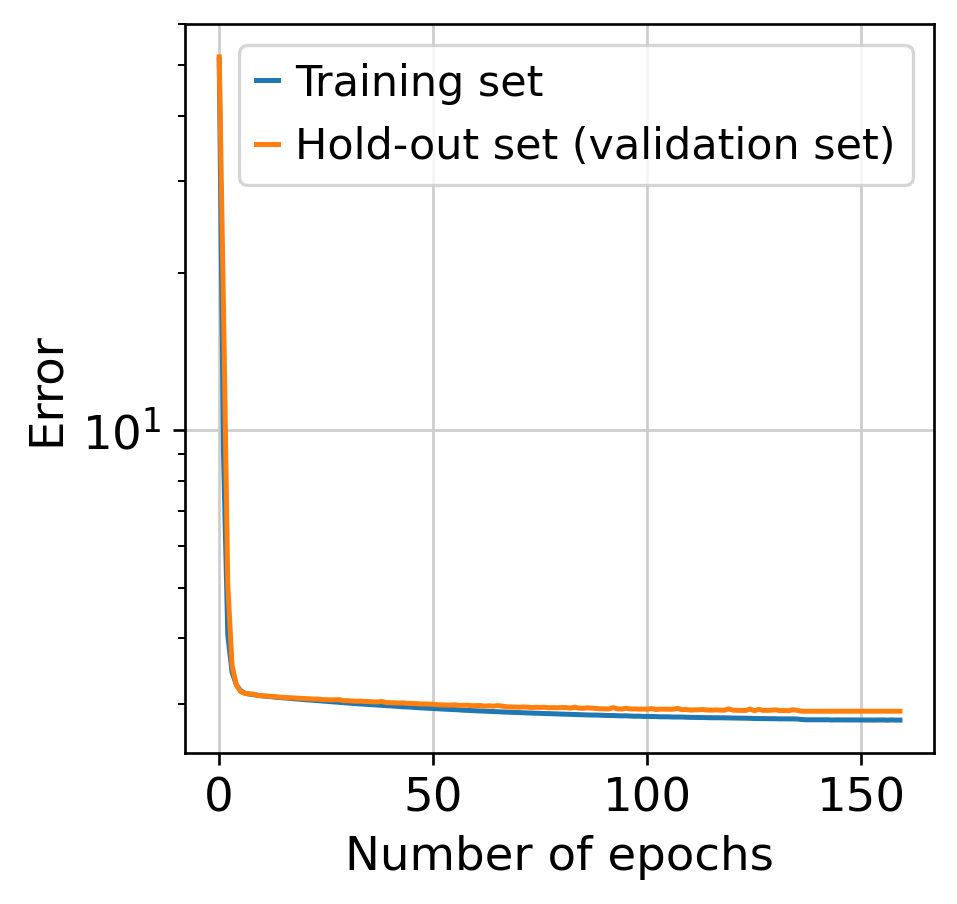

In [6]:
valloss = dca_zinb.uns['dca_loss_history']['val_loss']
loss = dca_zinb.uns['dca_loss_history']['loss']
i = range(len(loss))

f, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(i, loss, i, valloss)
ax.semilogy()
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Error')
plt.legend(['Training set', 'Hold-out set (validation set)'])

In [7]:
dca_mse = dca(sim_raw, ae_type='normal', threads=1, copy=True, normalize_per_cell=False, scale=False,
              training_kwds={'use_raw_as_output': False}, random_state=42)

dca_mse.X = np.exp(dca_mse.X) # bring MSE output back to normal scale

dca: Successfully preprocessed 195 genes and 2000 cells.


/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


In [8]:
dca_mse_norm = dca_mse.copy()

sc.pp.normalize_total(dca_mse_norm)
sc.pp.log1p(dca_mse_norm)
sc.pp.pca(dca_mse_norm)

/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Batch' as categorical
/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Batch' as categorical
/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versio

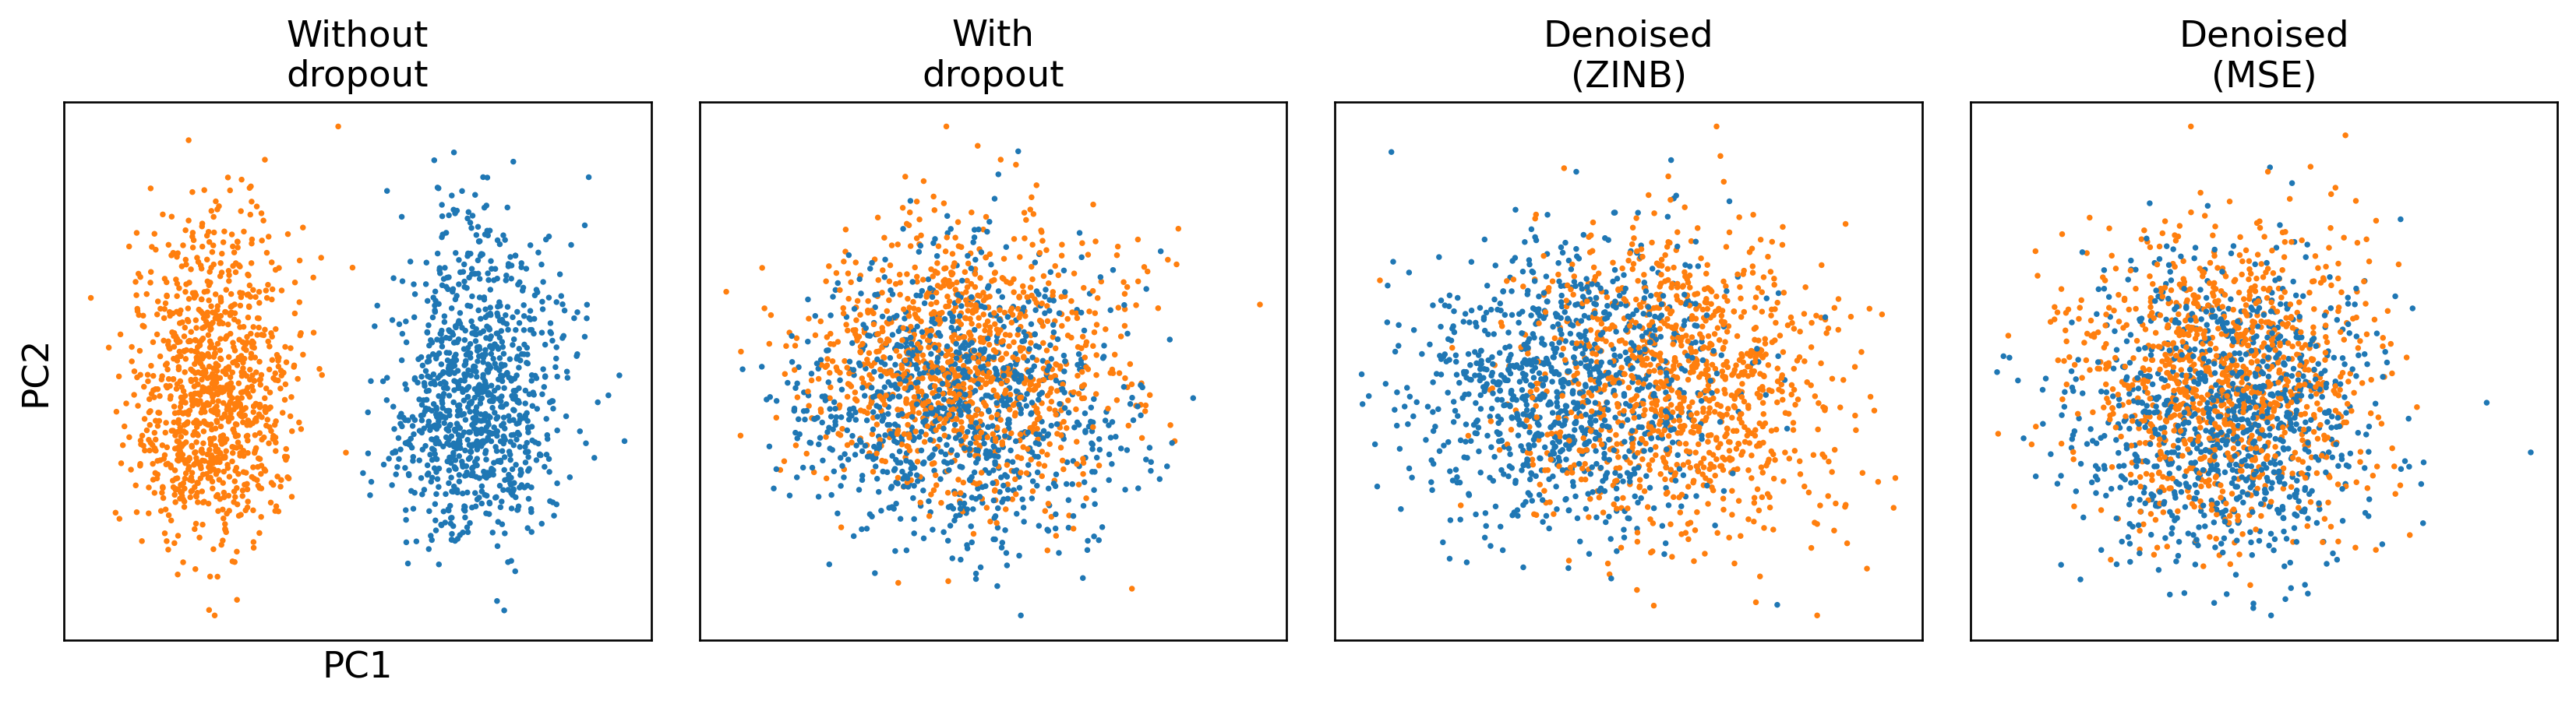

In [9]:
adatas = [sim_true_norm, sim_raw_norm, dca_zinb_norm, dca_mse_norm]
adata_labels = ['Without\ndropout', 'With\ndropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas), figsize=(14,4))

for i, (lbl, ad, ax) in enumerate(zip(adata_labels, adatas, axs)):
    sc.pl.pca_scatter(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()
#plt.savefig('two-group-pca.pdf')

<ipython-input-10-700add7eb1f6>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + adata_labels)


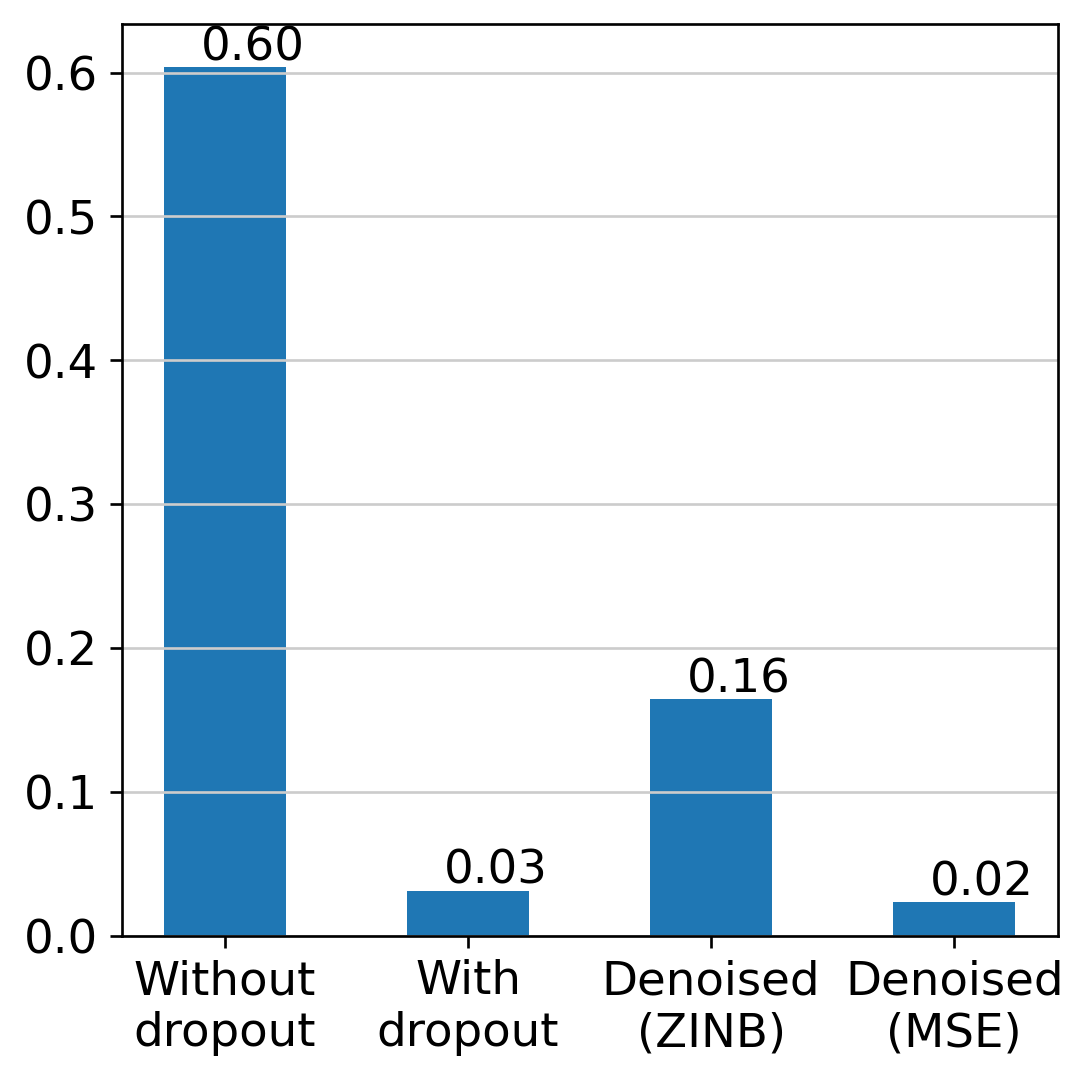

In [10]:
sils = np.array([silhouette_score(ad.obsm['X_pca'][:, :2], 
                 ad.obs.Group) for ad in adatas])

f, ax = plt.subplots(figsize=(5,5))
ax.grid(axis='x')

# Choose the width of each bar and their positions
width = 5
x_pos = [10,20,30,40]
 
# Make the plot
ax.bar(x_pos, sils, width=width)
ax.set_xticklabels([''] + adata_labels)

for x, t in zip(x_pos, sils):
    ax.text(x-1, t+0.005, '%.2f' % t)

/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


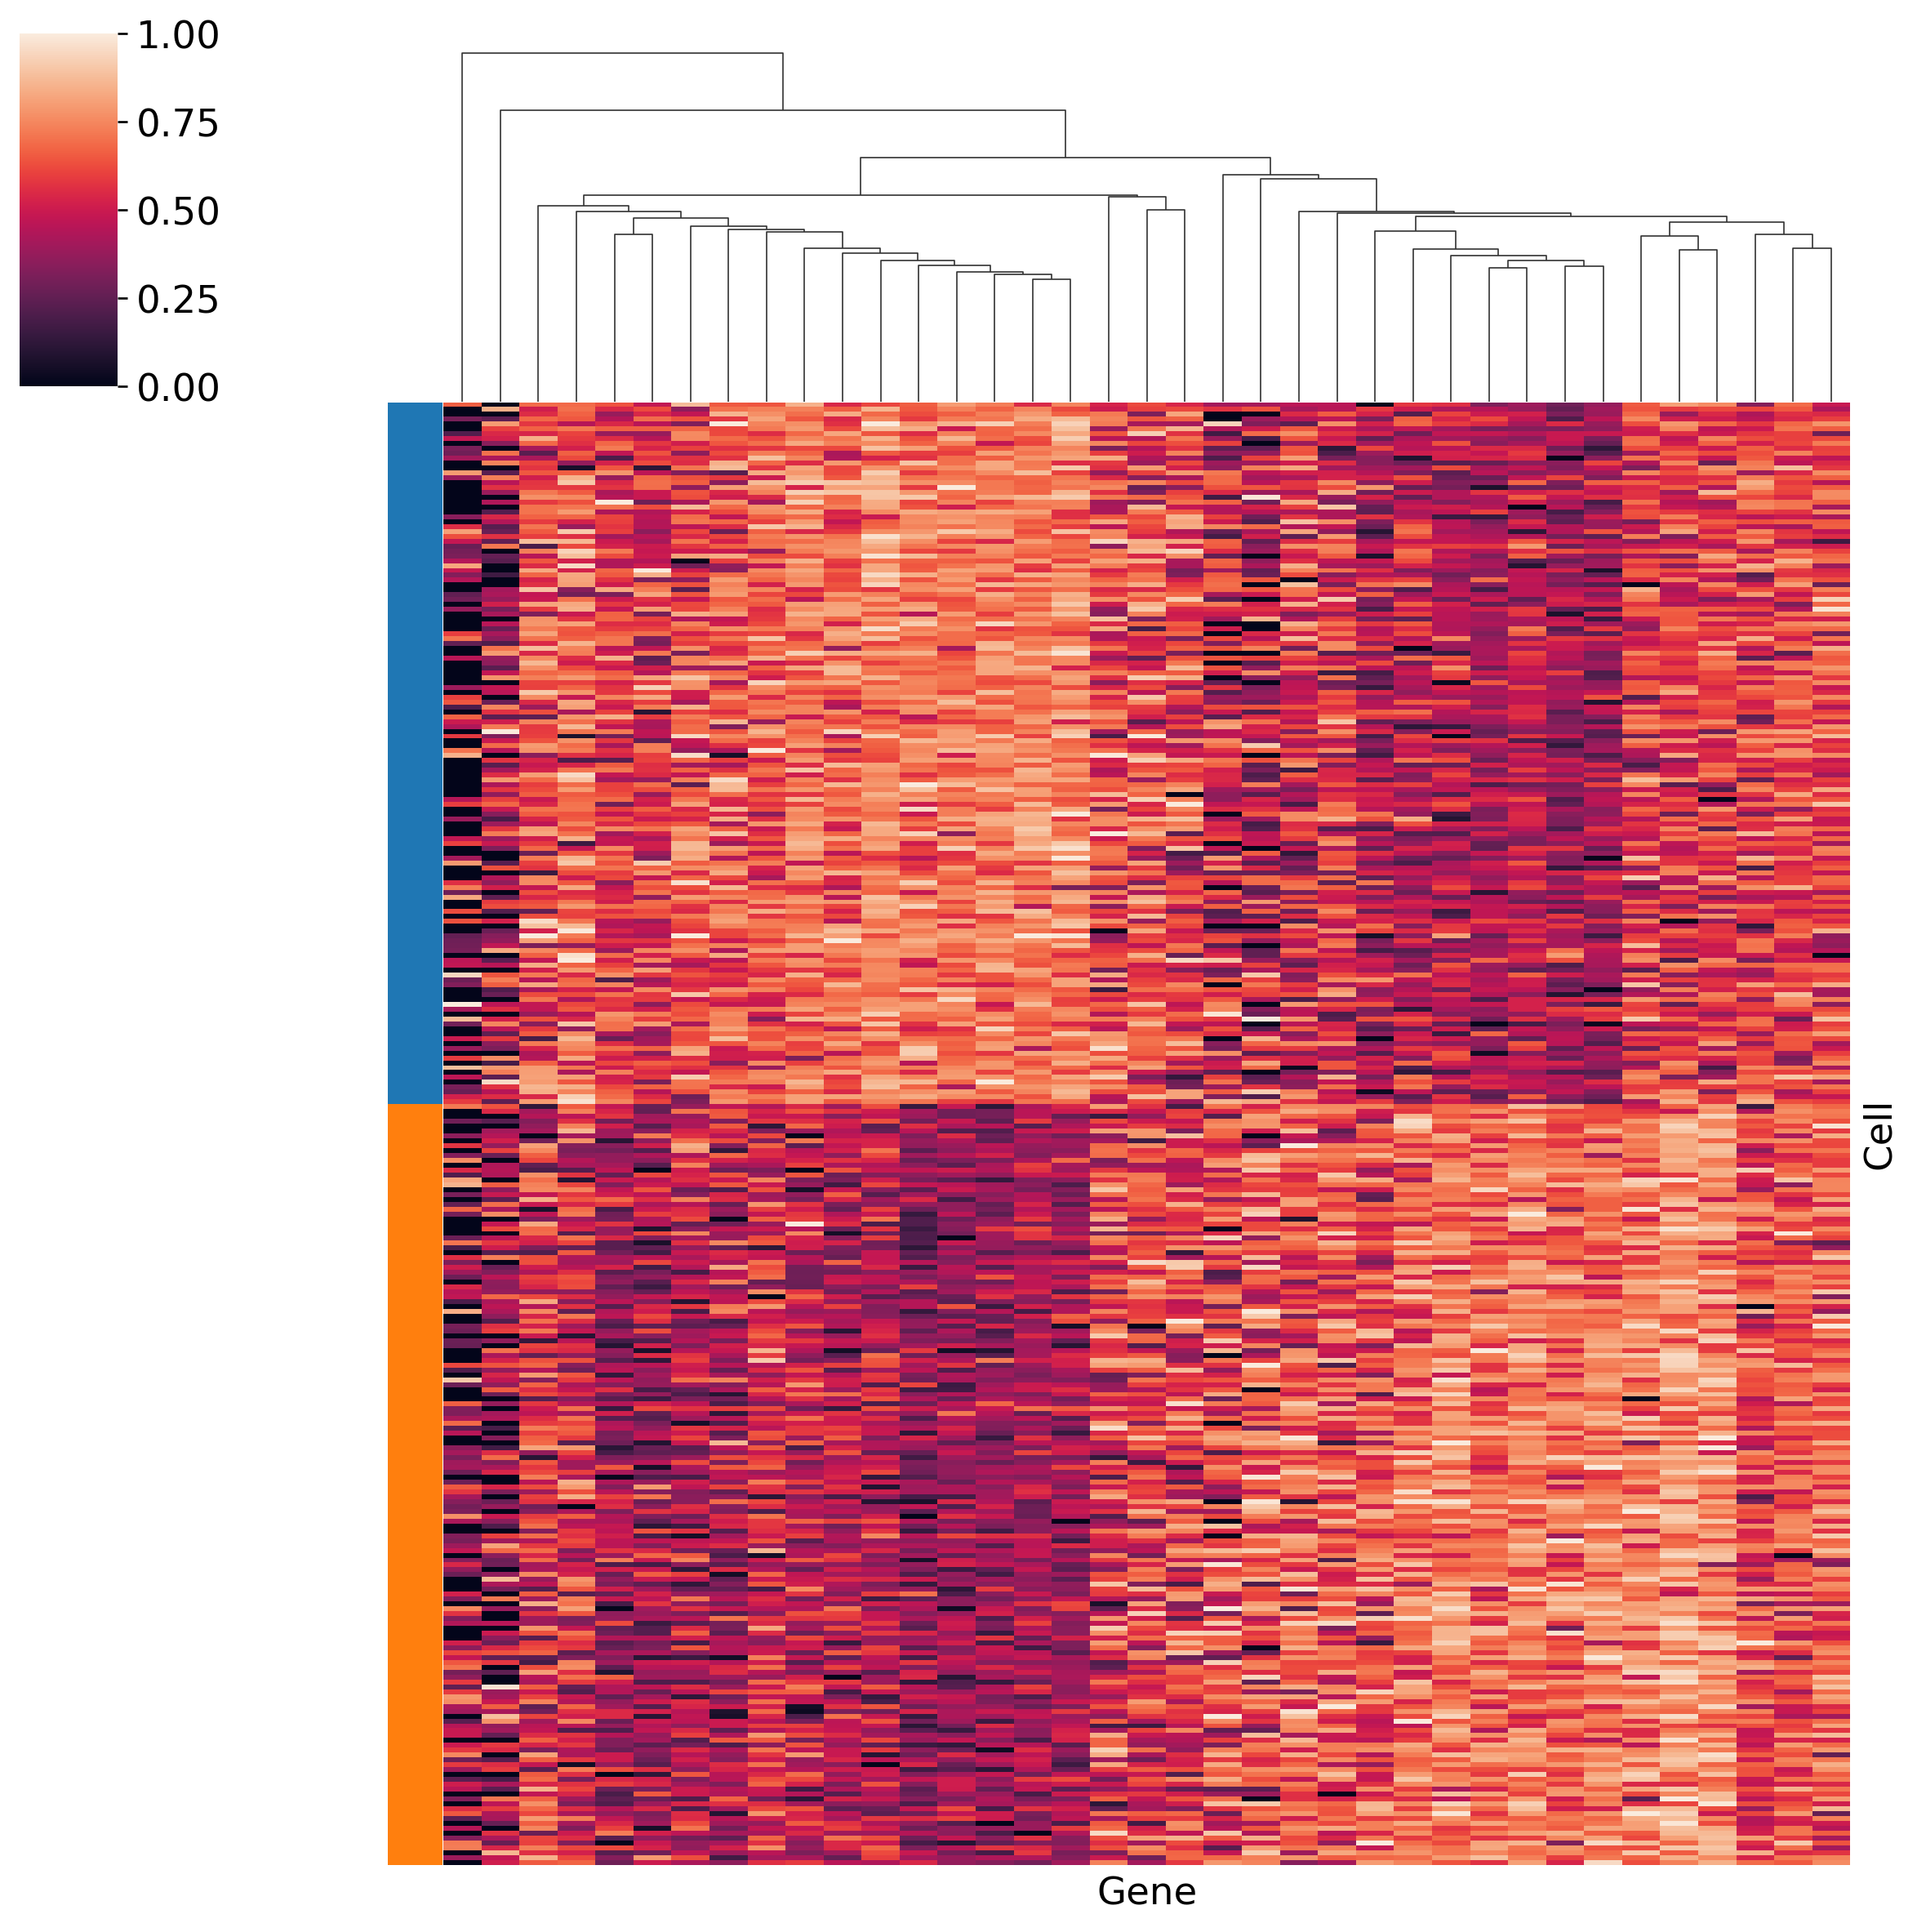

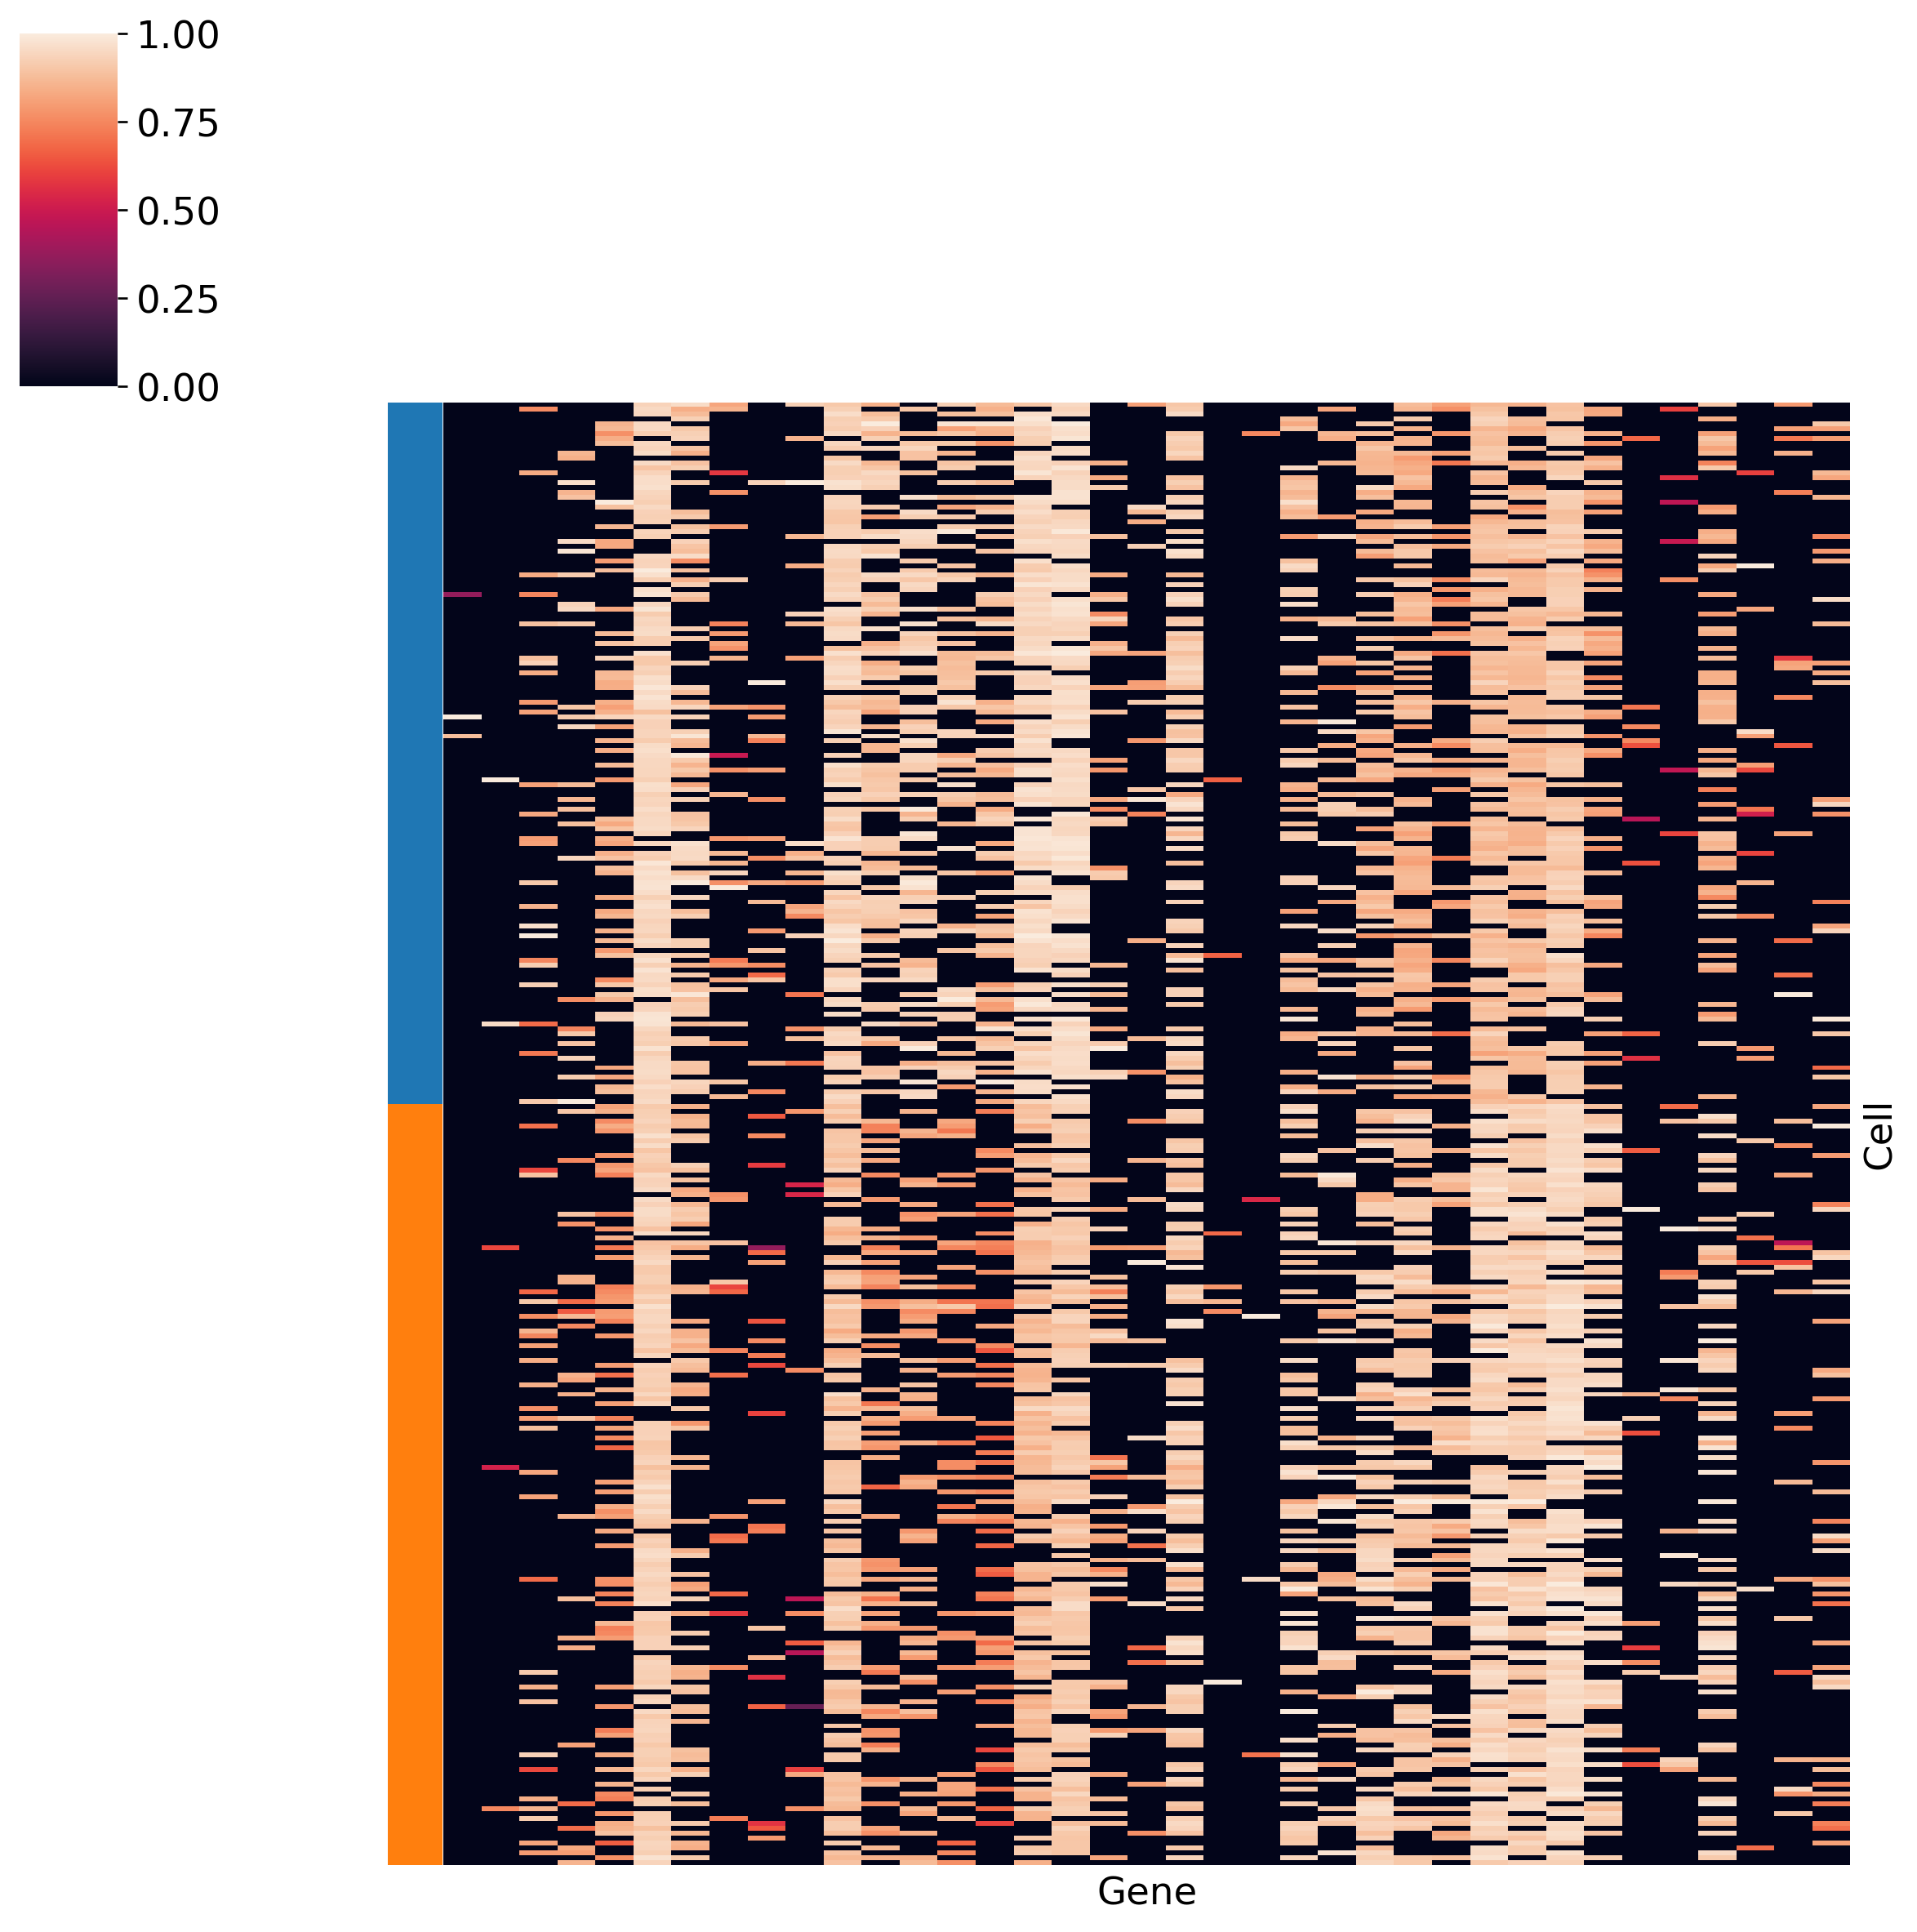

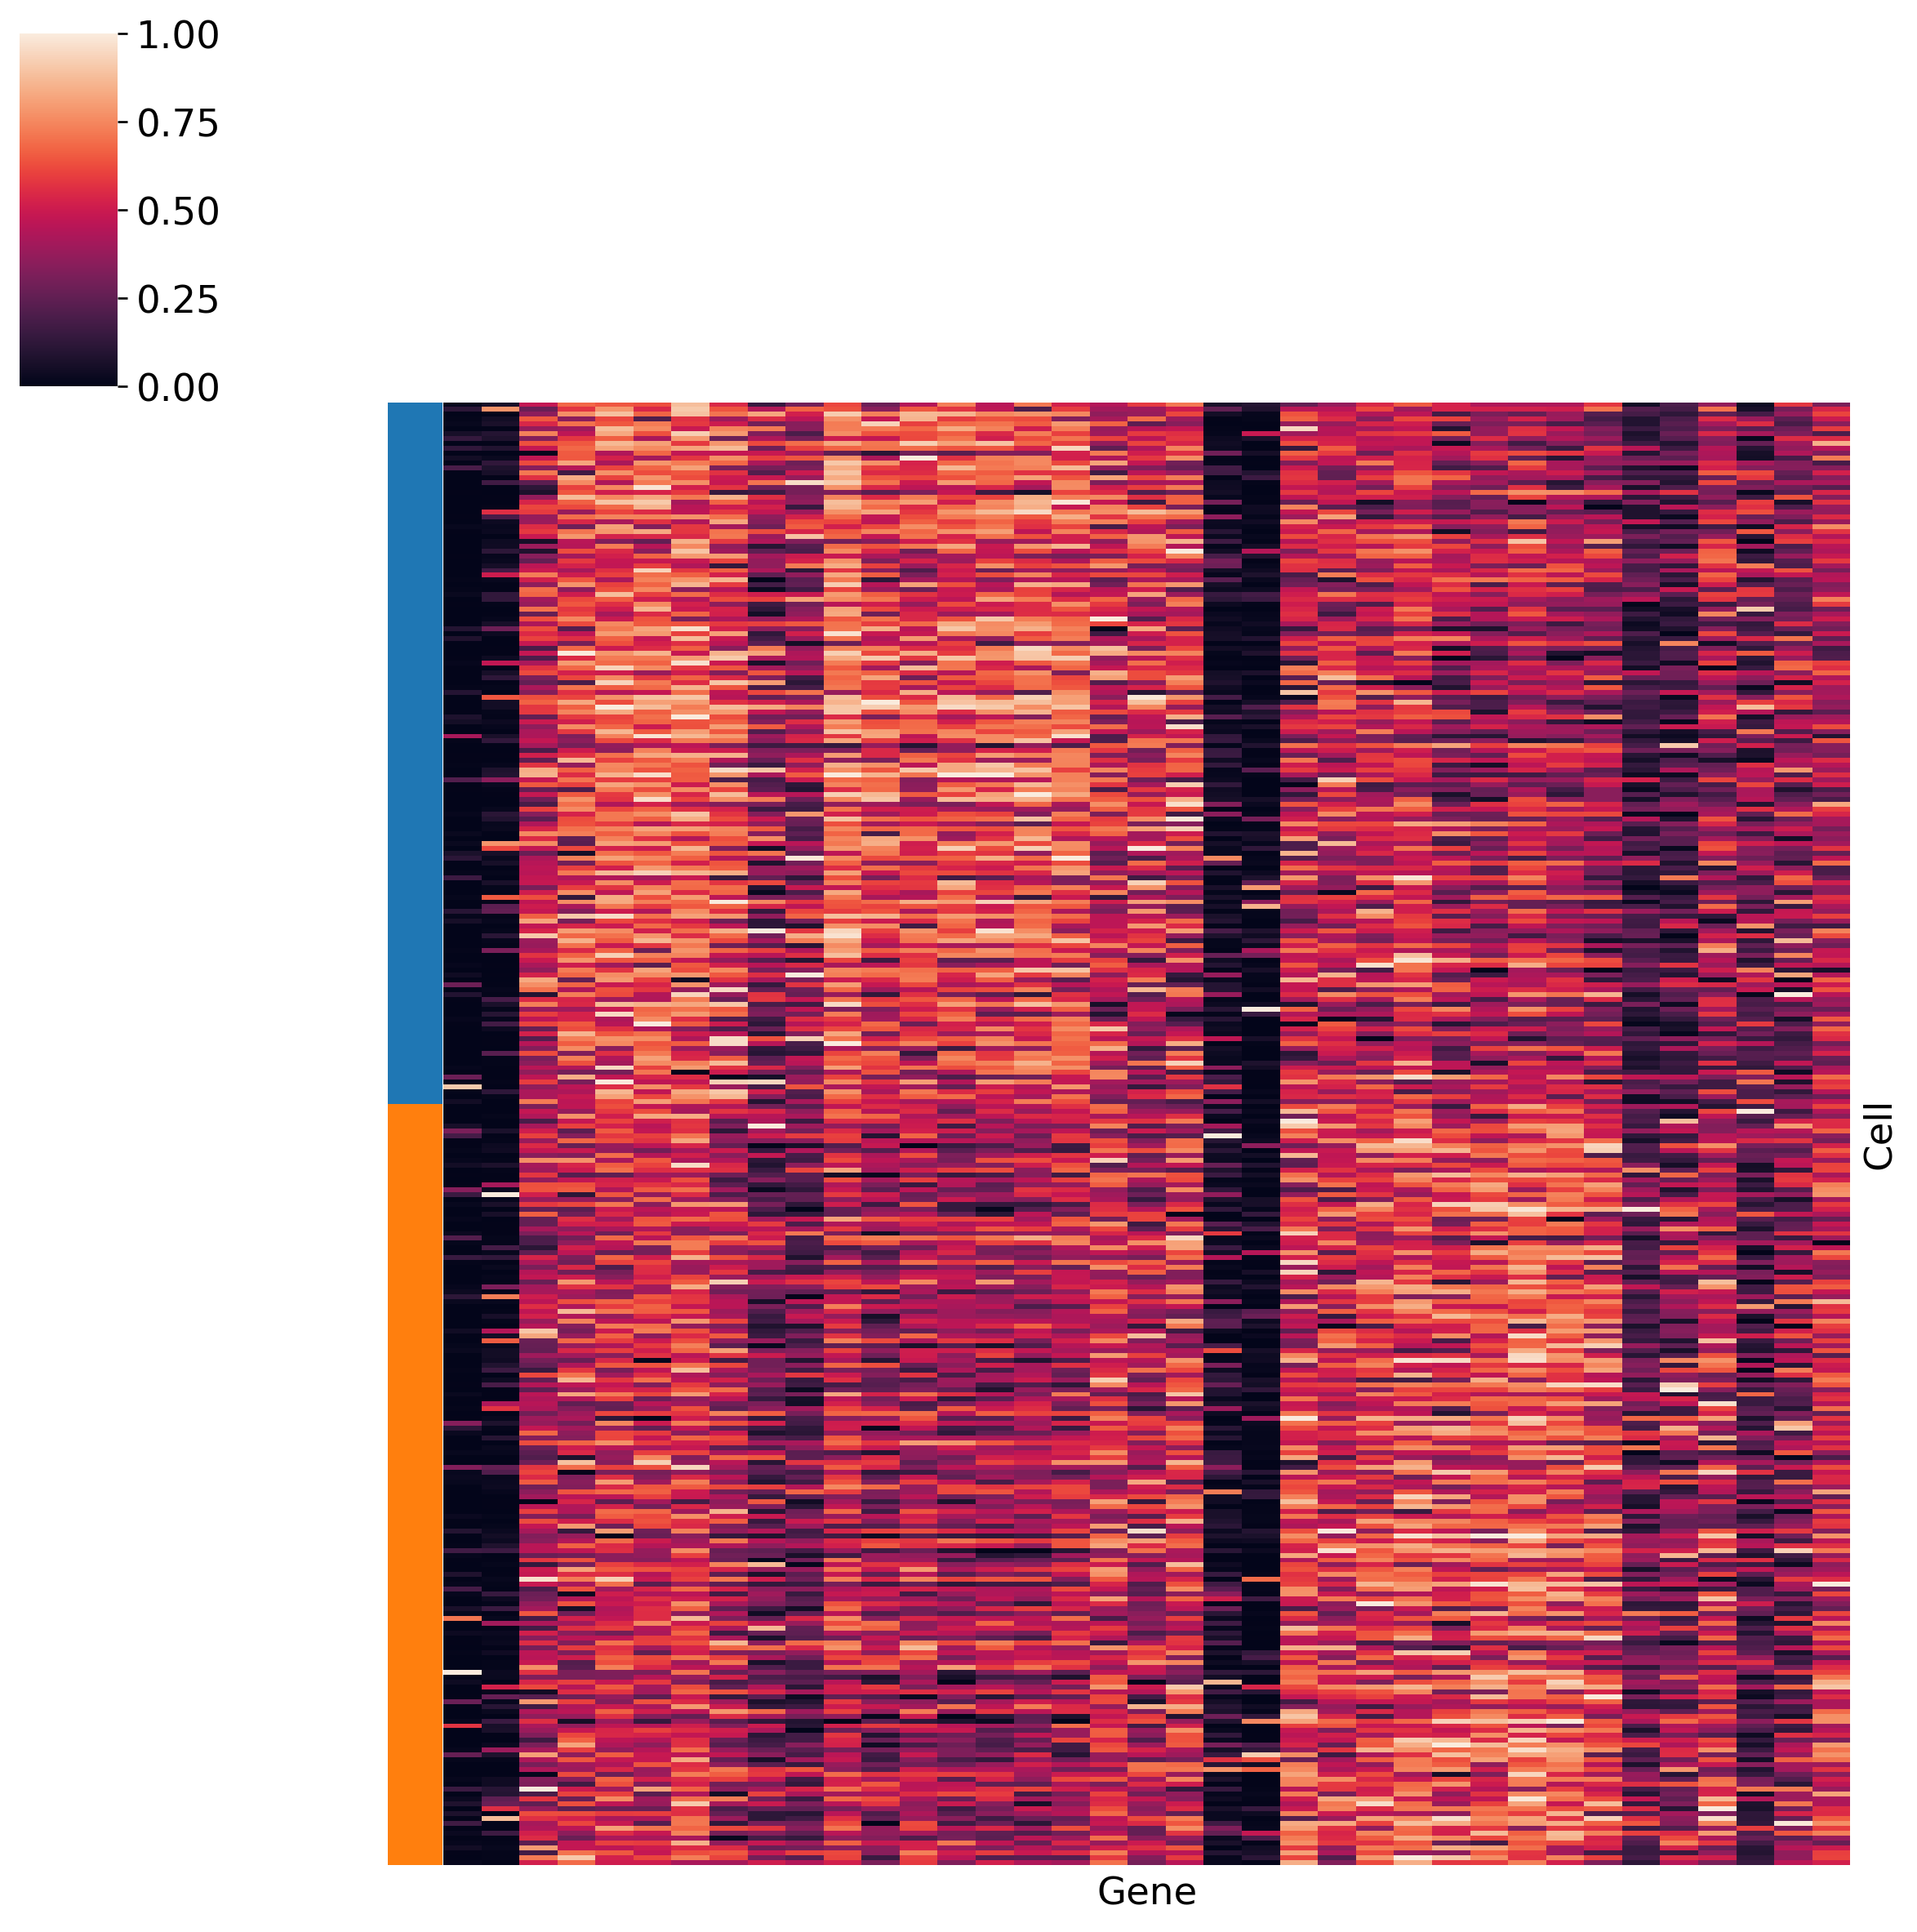

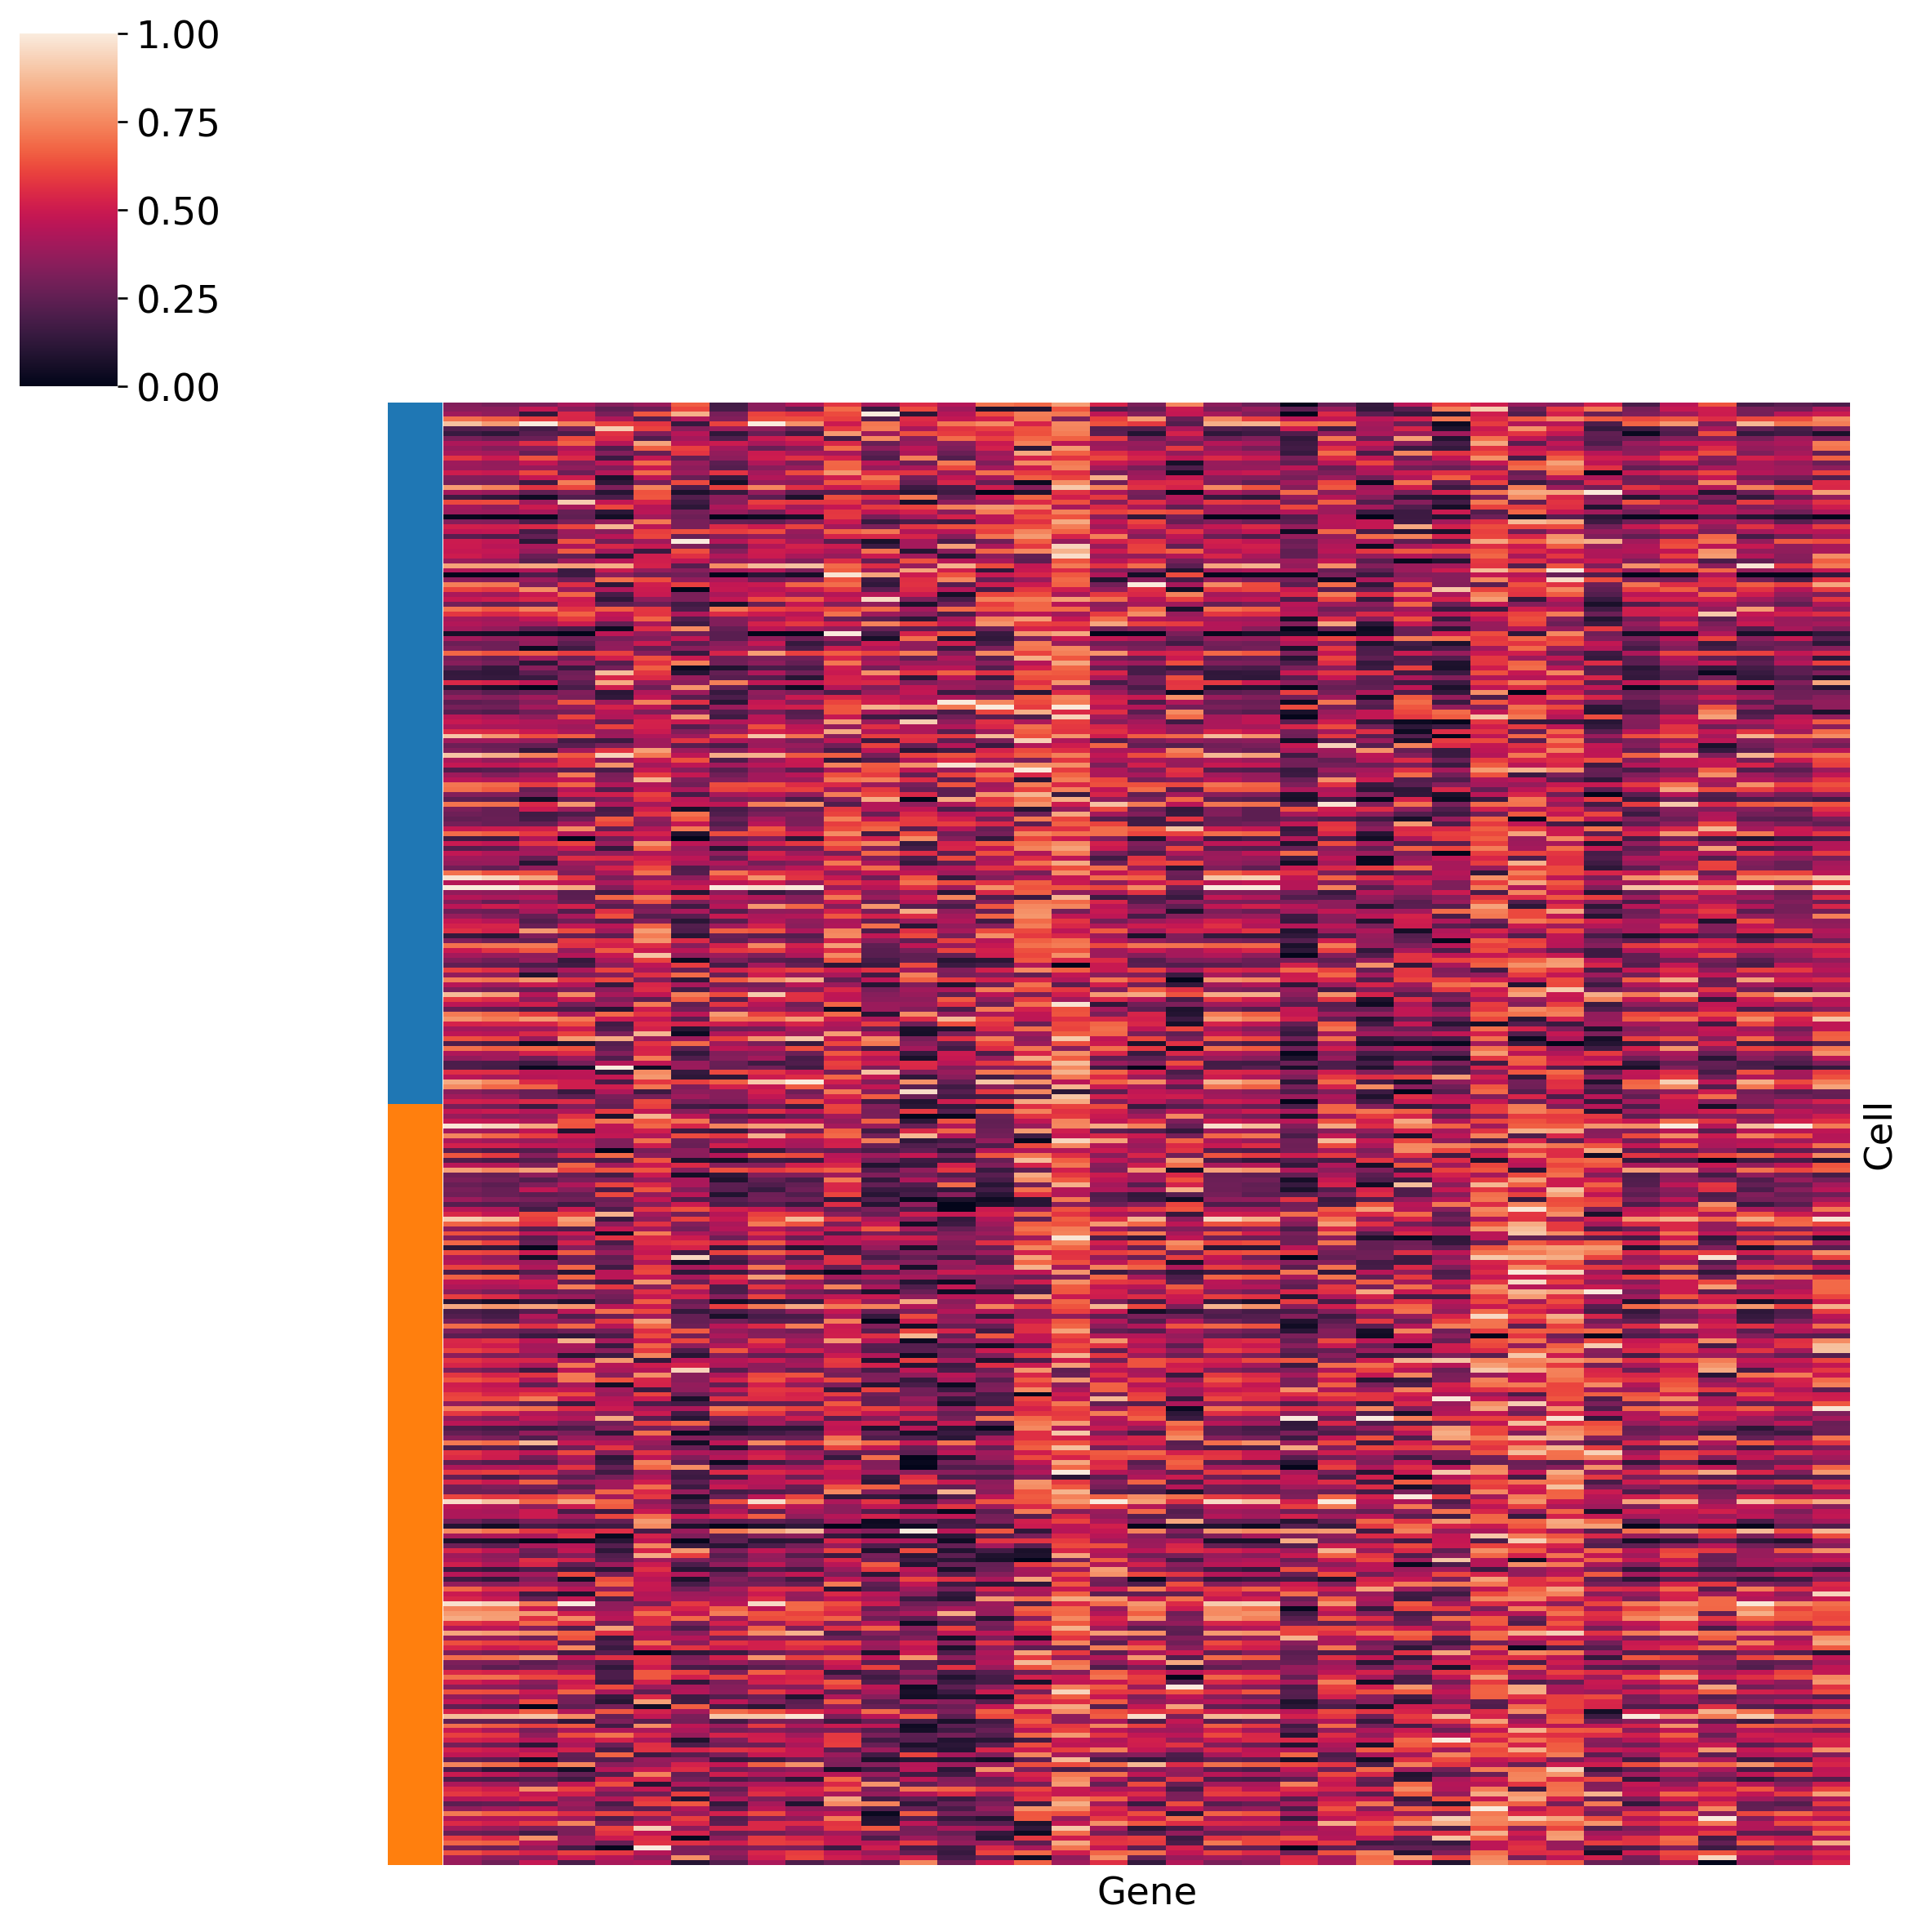

In [11]:
de_genes = np.where(sim_true_norm.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)[0]

obs_idx = np.random.choice(list(range(sim_raw_norm.n_obs)), 300, replace=False)
idx = np.argsort(sim_true_norm.obs.Group.values[obs_idx])
obs_idx = obs_idx[idx]

ax = sc.pl.clustermap(sim_true_norm[obs_idx, de_genes], 'Group', use_raw=False,
                      standard_scale=1, row_cluster=False, show=False, xticklabels=False, yticklabels=False)
ax.ax_row_dendrogram.set_visible(False)

gene_order = ax.dendrogram_col.reordered_ind # preserve gene order from true counts to make heatmaps easily comparable
de_genes = de_genes[gene_order]

ax = sc.pl.clustermap(sim_raw_norm[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_zinb_norm[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_mse_norm[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

## Comparison of ZINB, NB and MSE models

In [12]:
dca_nb = dca(sim_raw, ae_type='nb-conddisp', threads=1, copy=True, log1p=False)

dca: Successfully preprocessed 195 genes and 2000 cells.


/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


In [13]:
# !pip install kern_smooth
from kern_smooth import densCols

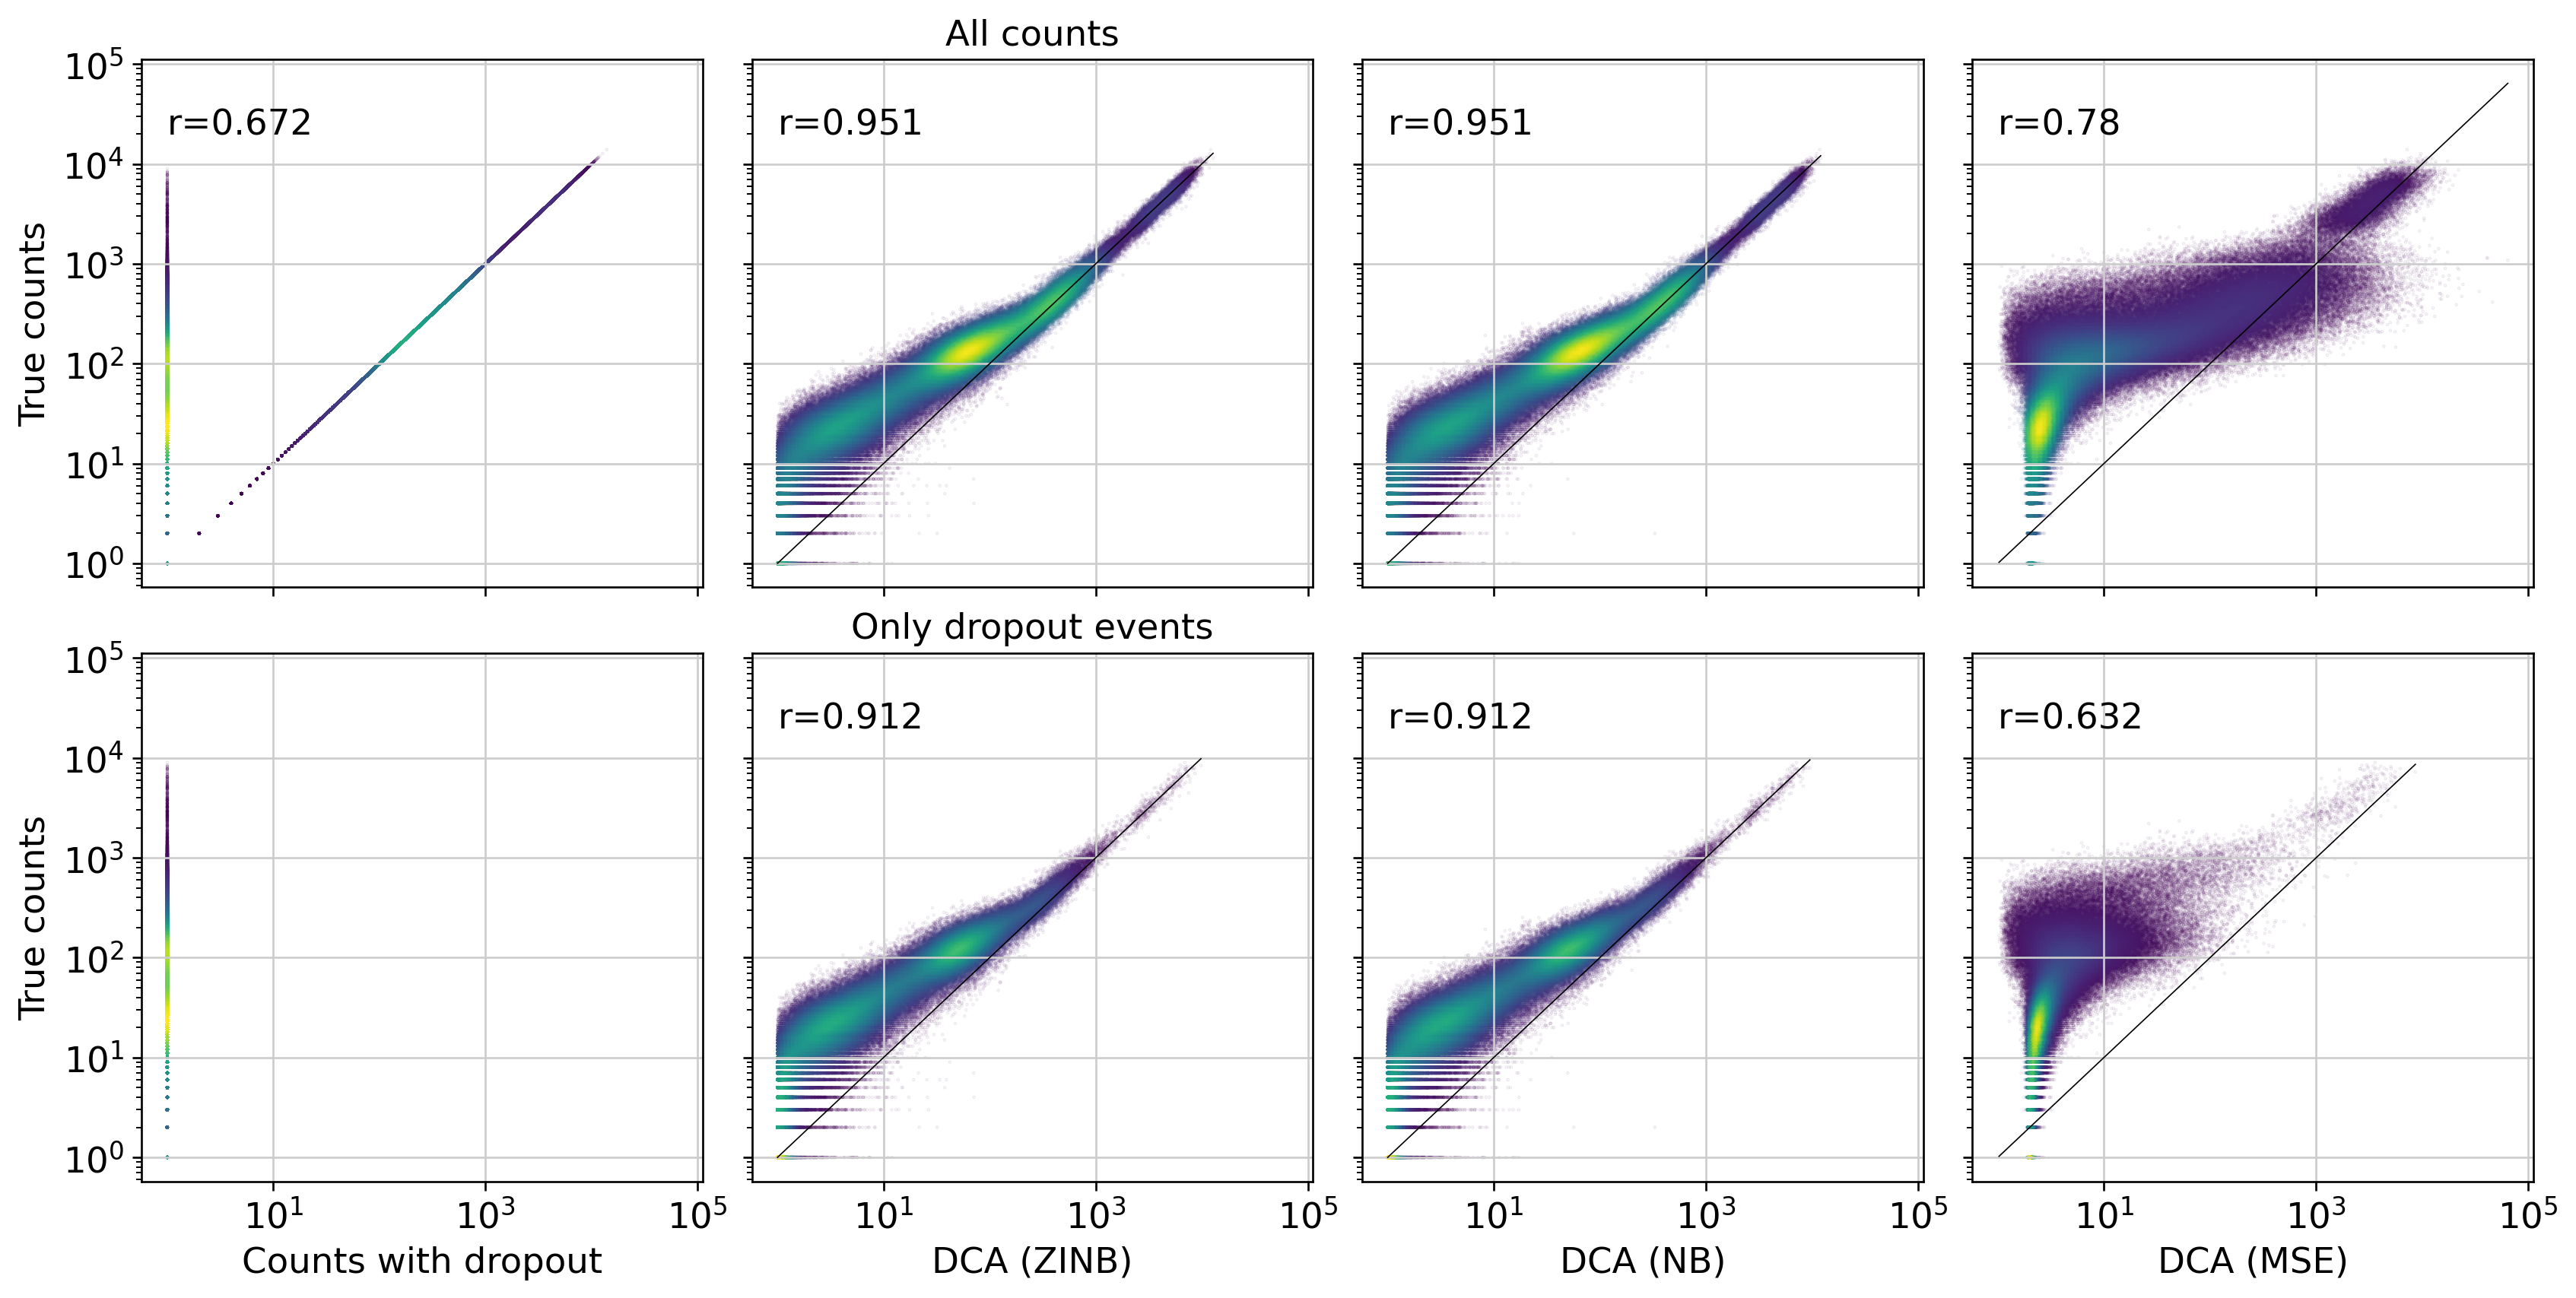

In [14]:
f, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14,7), constrained_layout=True)

adatas_raw = [sim_raw, dca_zinb, dca_nb, dca_mse]
adata_raw_labels = ['Counts with dropout', 'DCA (ZINB)', 'DCA (NB)', 'DCA (MSE)']
true_counts = sim_true.X.flatten()+1

for i, (ax, ad, lbl) in enumerate(zip(axes[0], adatas_raw, adata_raw_labels)):
    x = ad.X.flatten()+1
    y = true_counts
    c = densCols(np.log10(x), np.log10(y))
    ax.scatter(x, y, s=0.1, alpha=0.1, c=c, marker='o')
    if i == 0: 
        ax.set_ylabel('True counts')
    else:
        ax.plot([min(x), max(x)], [min(x), max(x)], 'k-', linewidth=0.5)
    if i == 1:
        ax.set_title('All counts')        
    cor = np.corrcoef(np.log(x), np.log(y))[0, 1]
    ax.annotate(f'r={cor.round(3)}', (1, 20000))        
        
    ax.loglog()

true_dropout = true_counts[dropout_gt.flatten()==1]
for i, (ax, ad, lbl) in enumerate(zip(axes[1], adatas_raw, adata_raw_labels)):
    x = ad.X[dropout_gt==1]+1
    y = true_dropout
    c = densCols(np.log10(x), np.log10(y))
    ax.scatter(x, y, s=0.1, alpha=0.1, c=c, marker='o')

    if i==0: 
        ax.set_ylabel('True counts')
    else: 
        cor = np.corrcoef(np.log(x), np.log(y))[0, 1]
        ax.annotate(f'r={cor.round(3)}', (1, 20000))                              
        ax.plot([min(x), max(x)], [min(x), max(x)], 'k-', linewidth=0.5)
    if i == 1:
        ax.set_title('Only dropout events')        

    ax.loglog()
    ax.set_xlabel(lbl)

## Simulate six groups

In [15]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=3)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

2022-02-09 19:04:27,867 [WARNING] R[write to console]: Getting parameters...

2022-02-09 19:04:27,987 [WARNING] R[write to console]: Creating simulation object...

2022-02-09 19:04:28,236 [WARNING] R[write to console]: Simulating library sizes...

2022-02-09 19:04:28,255 [WARNING] R[write to console]: Simulating gene means...

2022-02-09 19:04:28,520 [WARNING] R[write to console]: Simulating group DE...

2022-02-09 19:04:28,660 [WARNING] R[write to console]: Simulating cell means...

2022-02-09 19:04:28,814 [WARNING] R[write to console]: Simulating BCV...

2022-02-09 19:04:29,060 [WARNING] R[write to console]: Simulating counts...

2022-02-09 19:04:29,254 [WARNING] R[write to console]: Simulating dropout (if needed)...

2022-02-09 19:04:29,609 [WARNING] R[write to console]: Sparsifying assays...

2022-02-09 19:04:29,619 [WARNING] R[write to console]: Automatically converting to sparse matrices, threshold = 0.95

2022-02-09 19:04:29,670 [WARNING] R[write to console]: Skipping 'BatchCell

In [16]:
sim_raw6 = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw6.obs_names = cellinfo.Cell
sim_raw6.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw6, min_counts=1)

sim_true6 = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true6.obs_names = cellinfo.Cell
sim_true6.var_names = geneinfo.Gene
sim_true6 = sim_true6[:, sim_raw6.var_names].copy()
sim_true6

sim_raw_norm6 = sim_raw6.copy()
sc.pp.normalize_total(sim_raw_norm6)
sc.pp.log1p(sim_raw_norm6)
sc.pp.pca(sim_raw_norm6)
sc.pp.neighbors(sim_raw_norm6)
sc.tl.umap(sim_raw_norm6)

sim_true_norm6 = sim_true6.copy()
sc.pp.normalize_total(sim_true_norm6)
sc.pp.log1p(sim_true_norm6)
sc.pp.pca(sim_true_norm6)
sc.pp.neighbors(sim_true_norm6)
sc.tl.umap(sim_true_norm6)

print(sim_raw6)
print(sim_true6)

AnnData object with n_obs × n_vars = 2000 × 199
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
AnnData object with n_obs × n_vars = 2000 × 199
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'


## Denoise simulated data

In [17]:
%%time
dca_zinb6 = dca(sim_raw6, threads=1, copy=True, log1p=False, random_state=42)

dca: Successfully preprocessed 199 genes and 2000 cells.


/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
CPU times: user 1min 2s, sys: 962 ms, total: 1min 3s
Wall time: 1min 10s


In [18]:
dca_zinb_norm6 = dca_zinb6.copy()
sc.pp.normalize_total(dca_zinb_norm6)
sc.pp.log1p(dca_zinb_norm6)
sc.pp.pca(dca_zinb_norm6)
sc.pp.neighbors(dca_zinb_norm6)
sc.tl.umap(dca_zinb_norm6)

In [19]:
dca_mse6 = dca(sim_raw6, ae_type='normal', threads=1, copy=True, random_state=42,
               training_kwds={'use_raw_as_output': False}, normalize_per_cell=False, scale=False)

dca_mse_norm6 = dca_mse6.copy()
sc.pp.normalize_total(dca_mse_norm6)
sc.pp.pca(dca_mse_norm6)
sc.pp.neighbors(dca_mse_norm6)
sc.tl.umap(dca_mse_norm6)

dca_mse6.X = np.exp(dca_mse6.X) # bring MSE output back to normal scale

dca: Successfully preprocessed 199 genes and 2000 cells.


/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Batch' as categorical
/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Batch' as categorical
/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versio

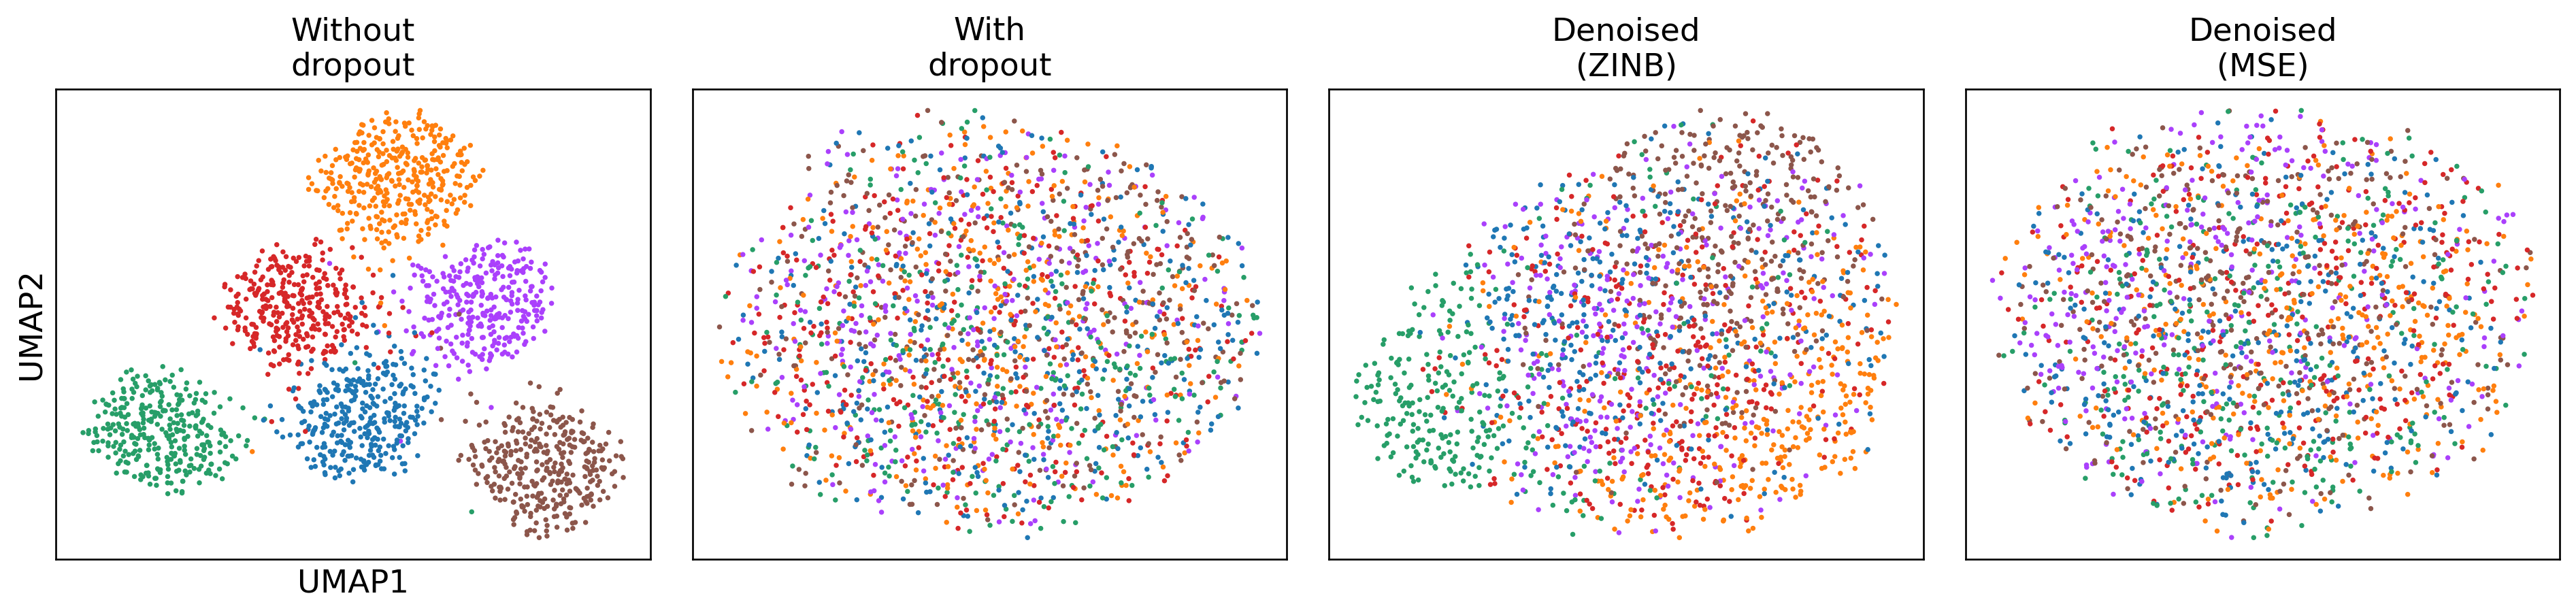

In [20]:
adatas6 = [sim_true_norm6, sim_raw_norm6, dca_zinb_norm6, dca_mse_norm6]
adata_labels6 = ['Without\ndropout', 'With\ndropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas6), figsize=(16,4))
for i, (lbl, ad, ax) in enumerate(zip(adata_labels6, adatas6, axs)):
    sc.pl.umap(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()

<ipython-input-21-9328522f7c26>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + adata_labels6)


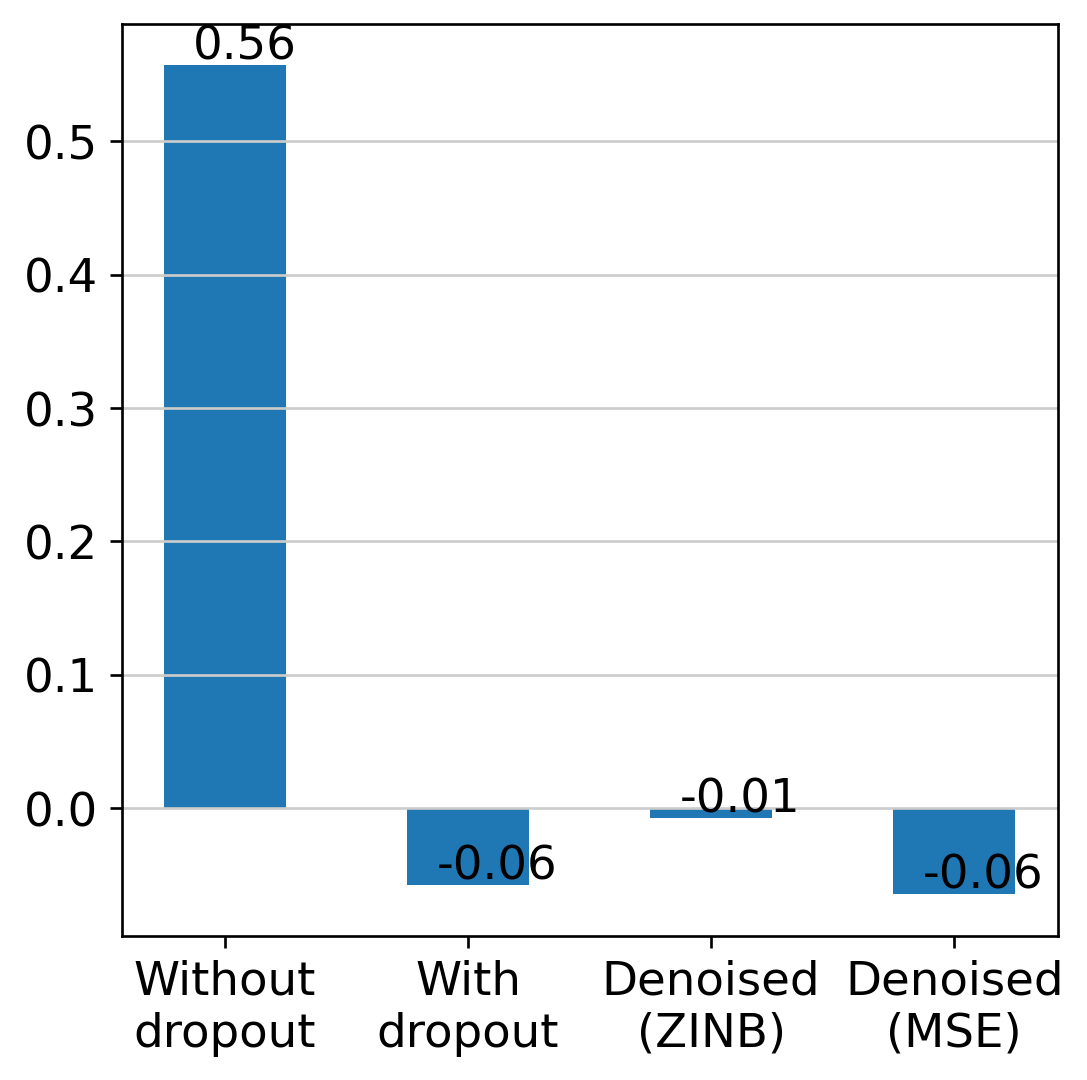

In [21]:
from sklearn.metrics import silhouette_score
sils6 = np.array([silhouette_score(ad.obsm['X_umap'], 
                 ad.obs.Group) for ad in adatas6])

f, ax = plt.subplots(figsize=(5,5))
ax.grid(axis='x')

# Choose the width of each bar and their positions
width = 5
x_pos = [10,20,30,40]
 
# Make the plot
ax.bar(x_pos, sils6, width=width)
ax.set_xticklabels([''] + adata_labels6)

for x, t in zip(x_pos, sils6):
    ax.text(x-1.3, t+0.005, '%.2f' % t)

/home/kaies/anaconda3/envs/csb/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


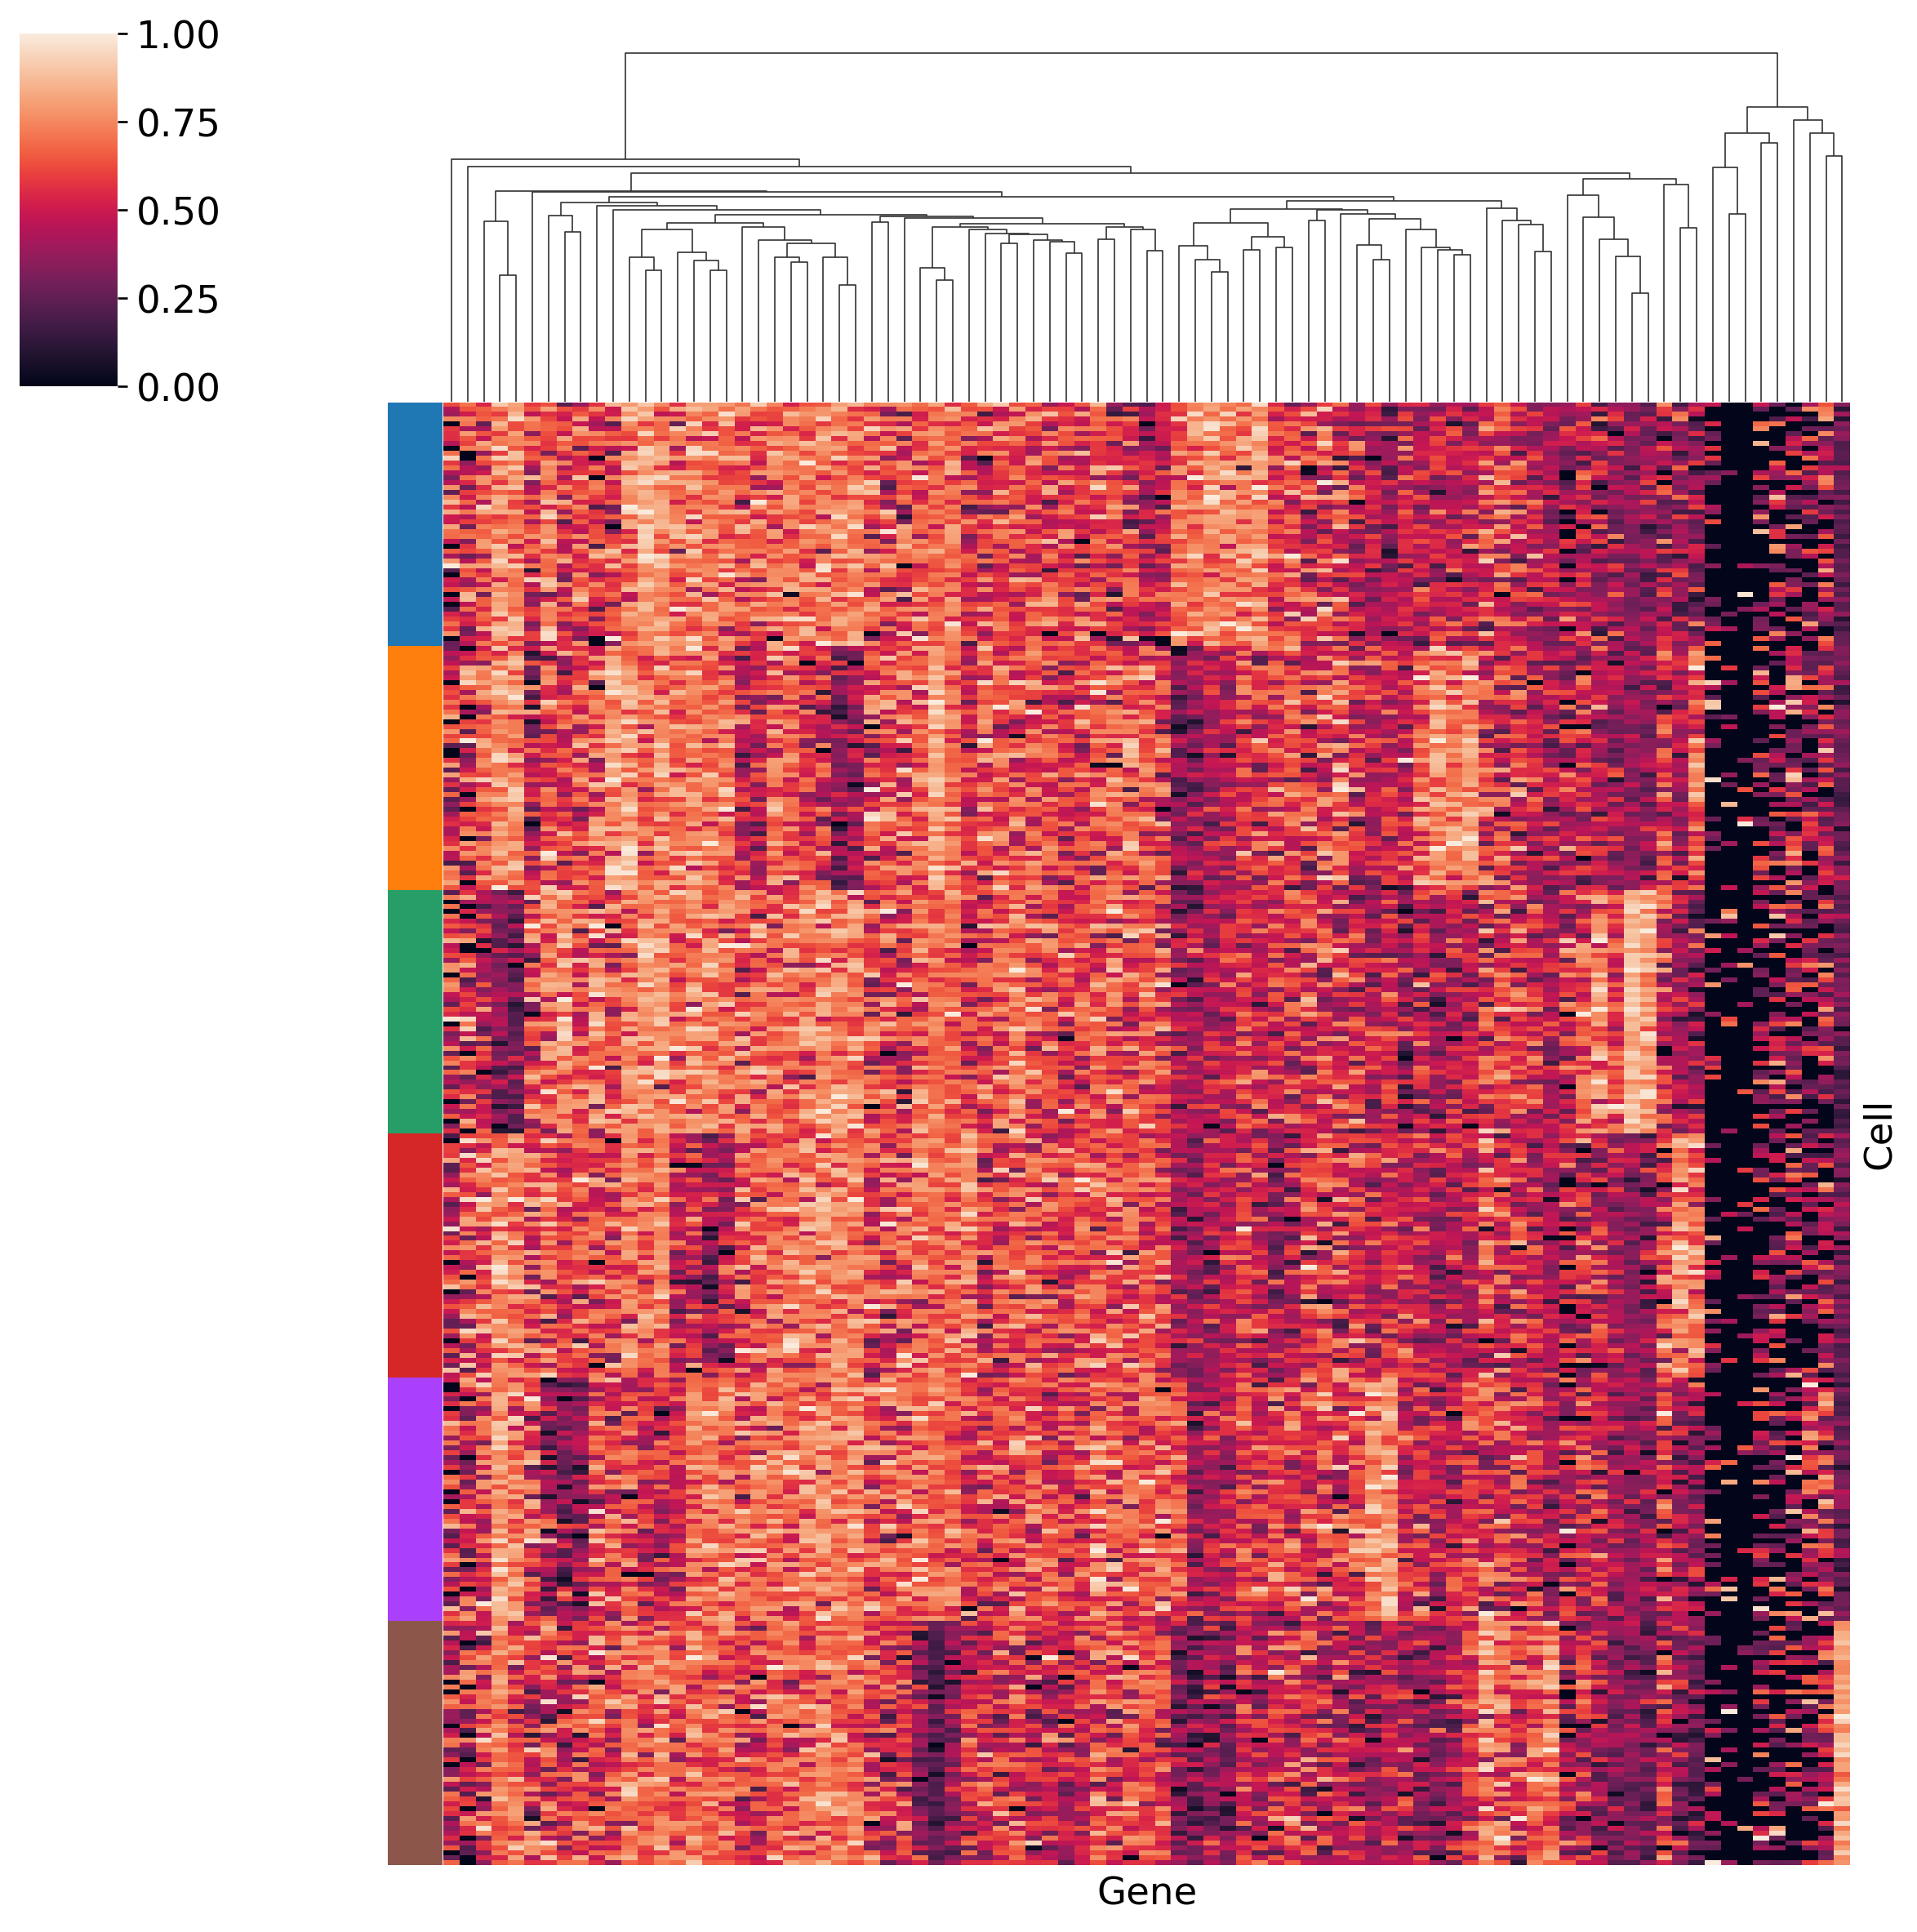

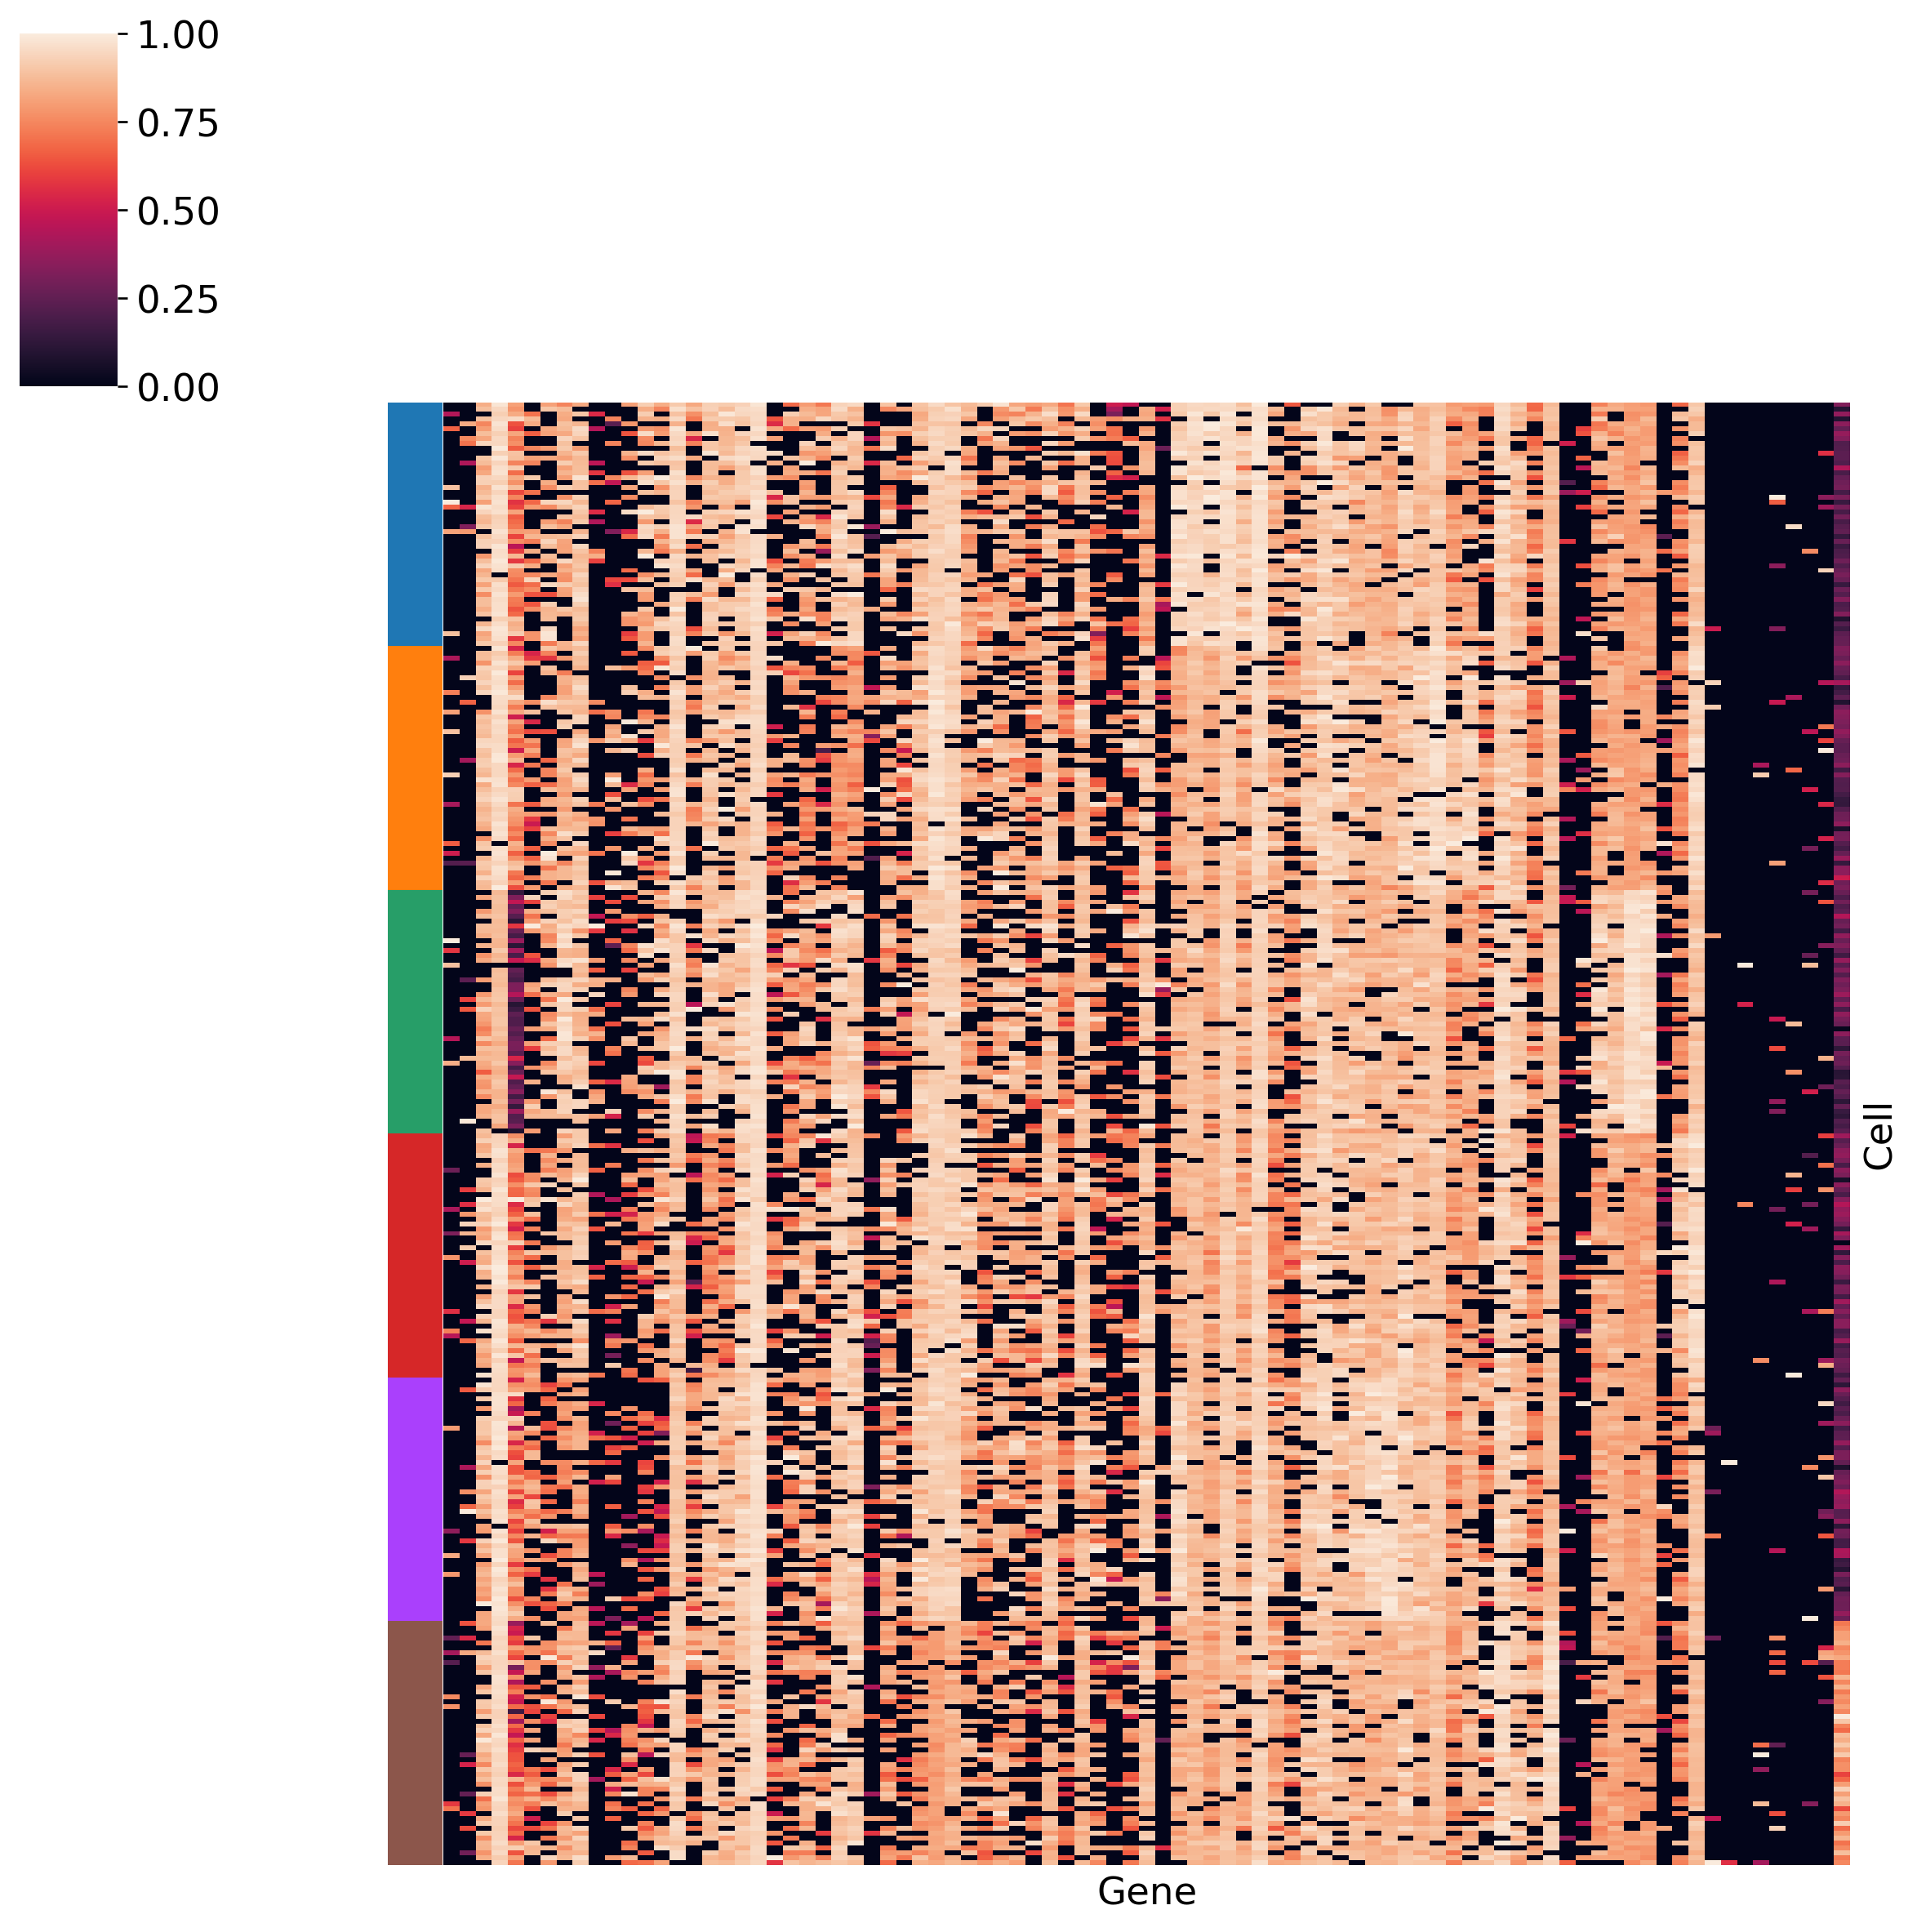

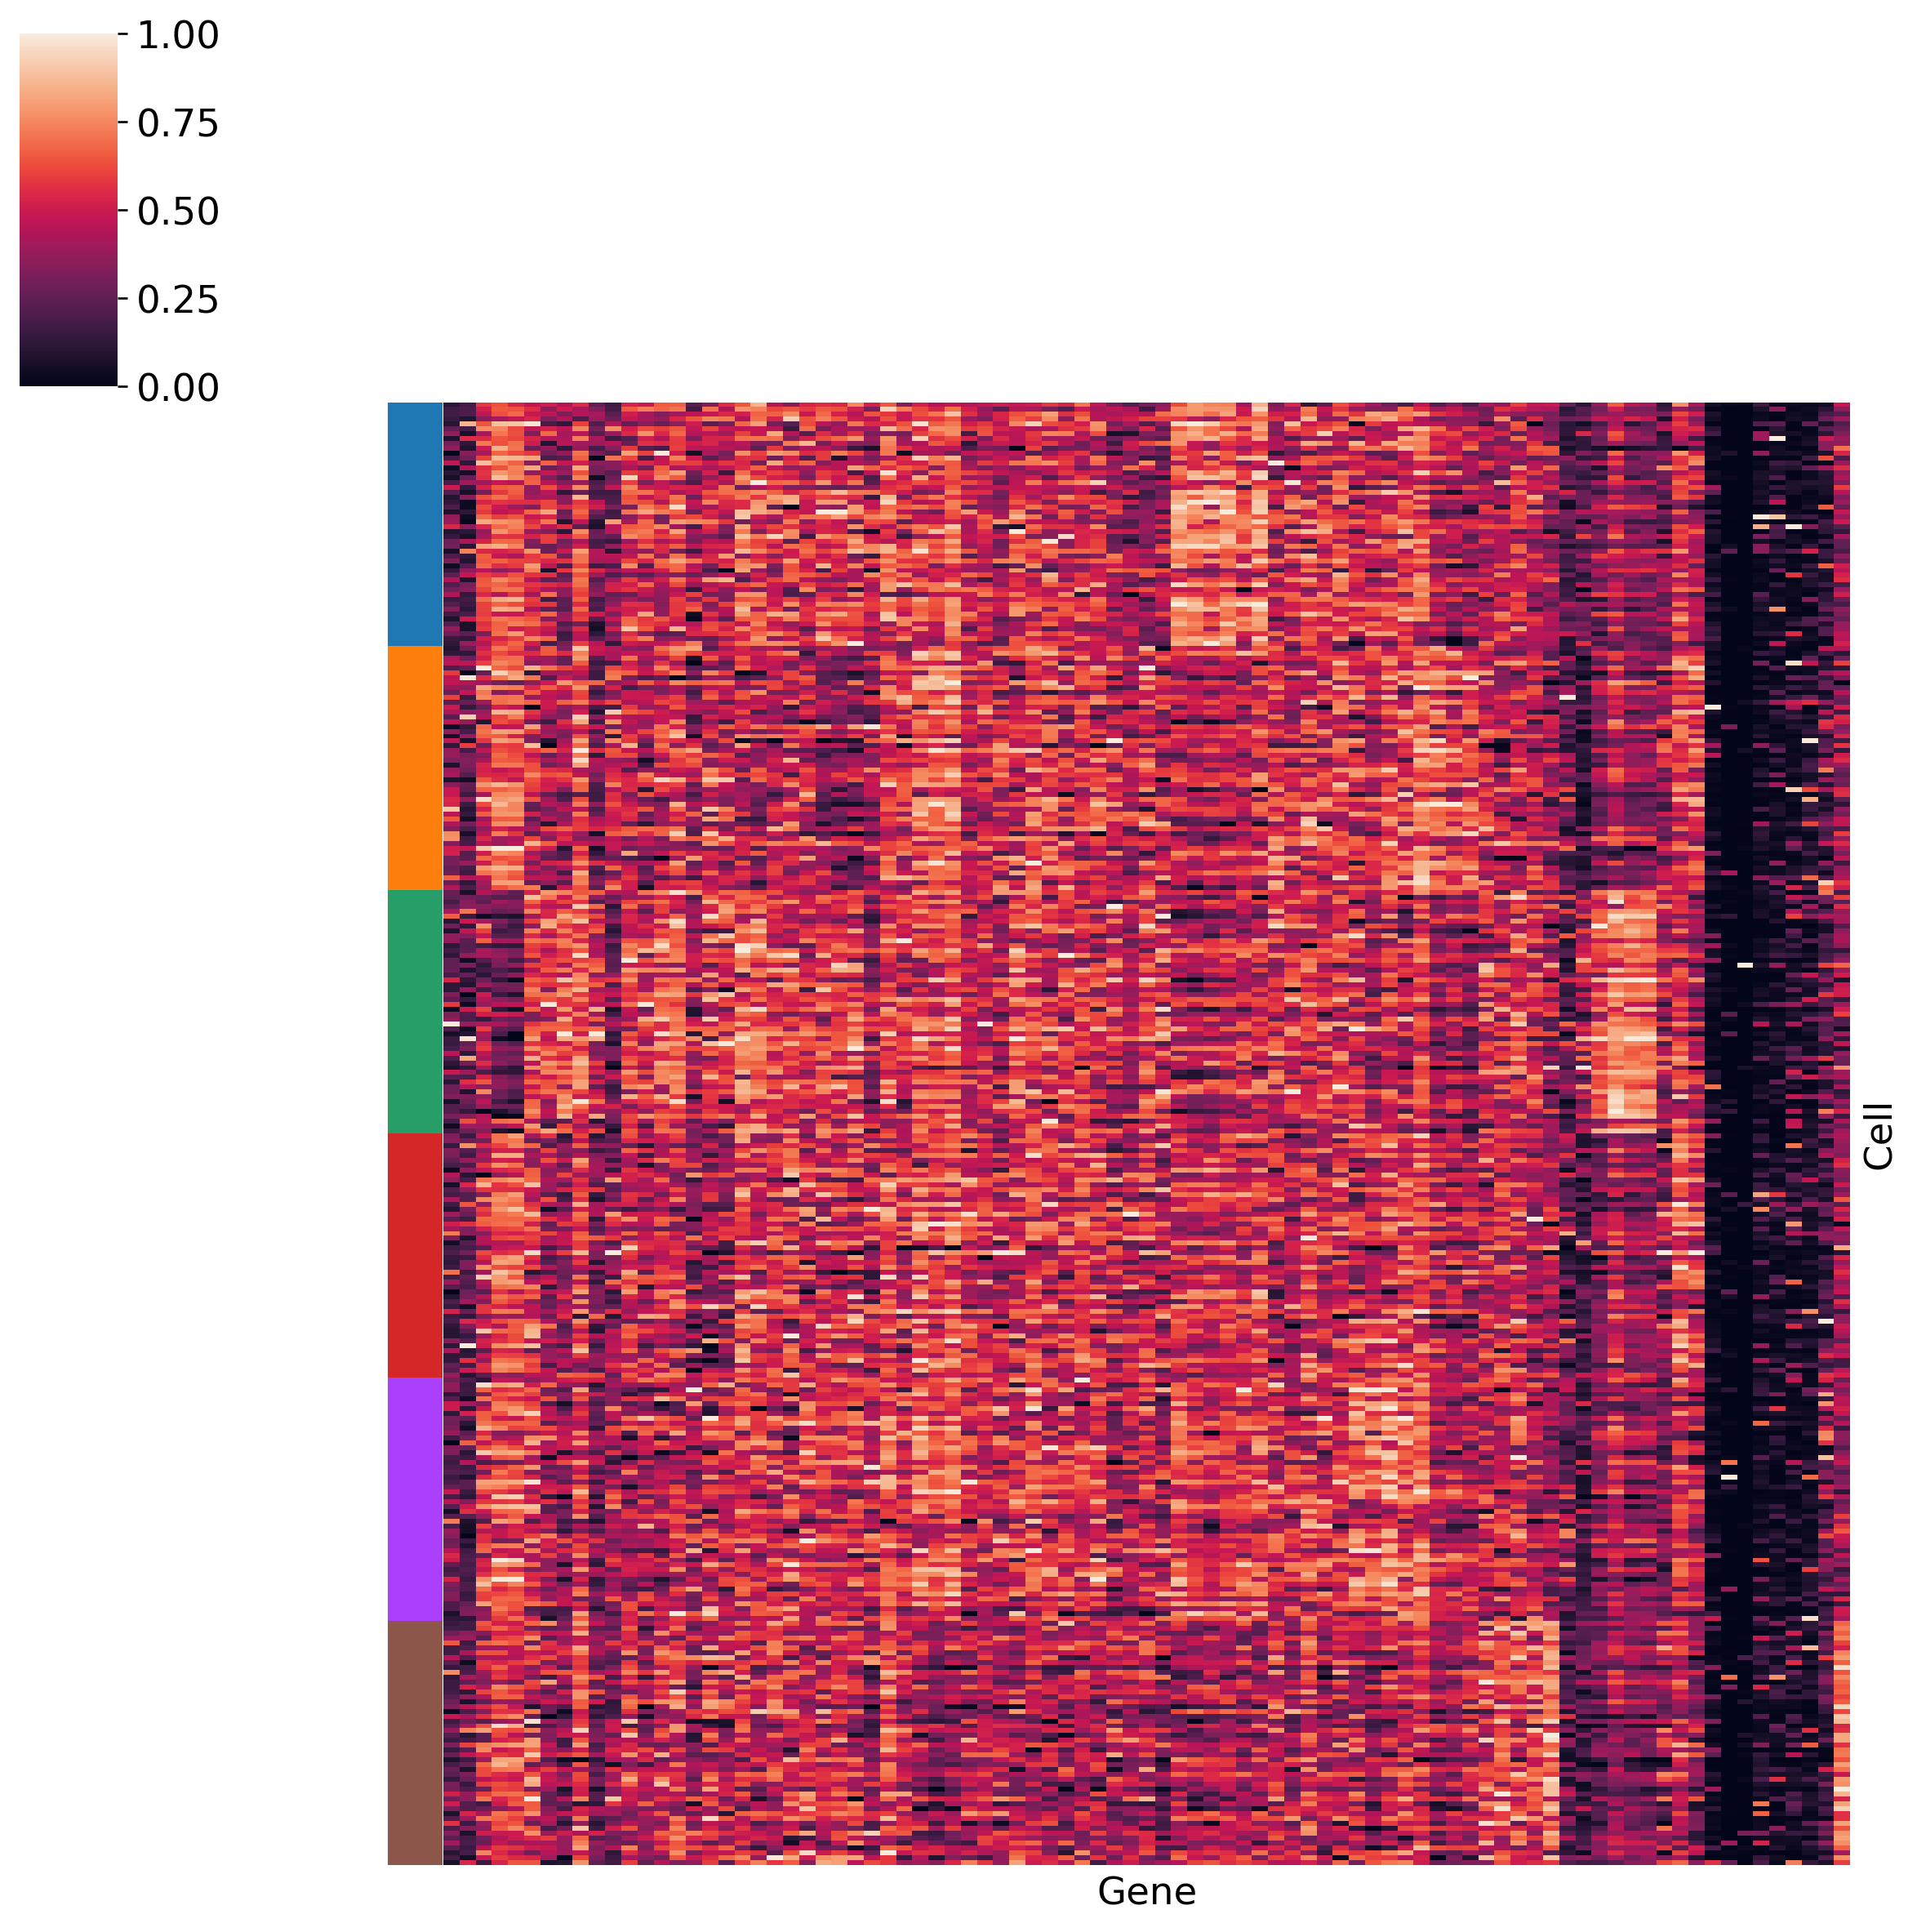

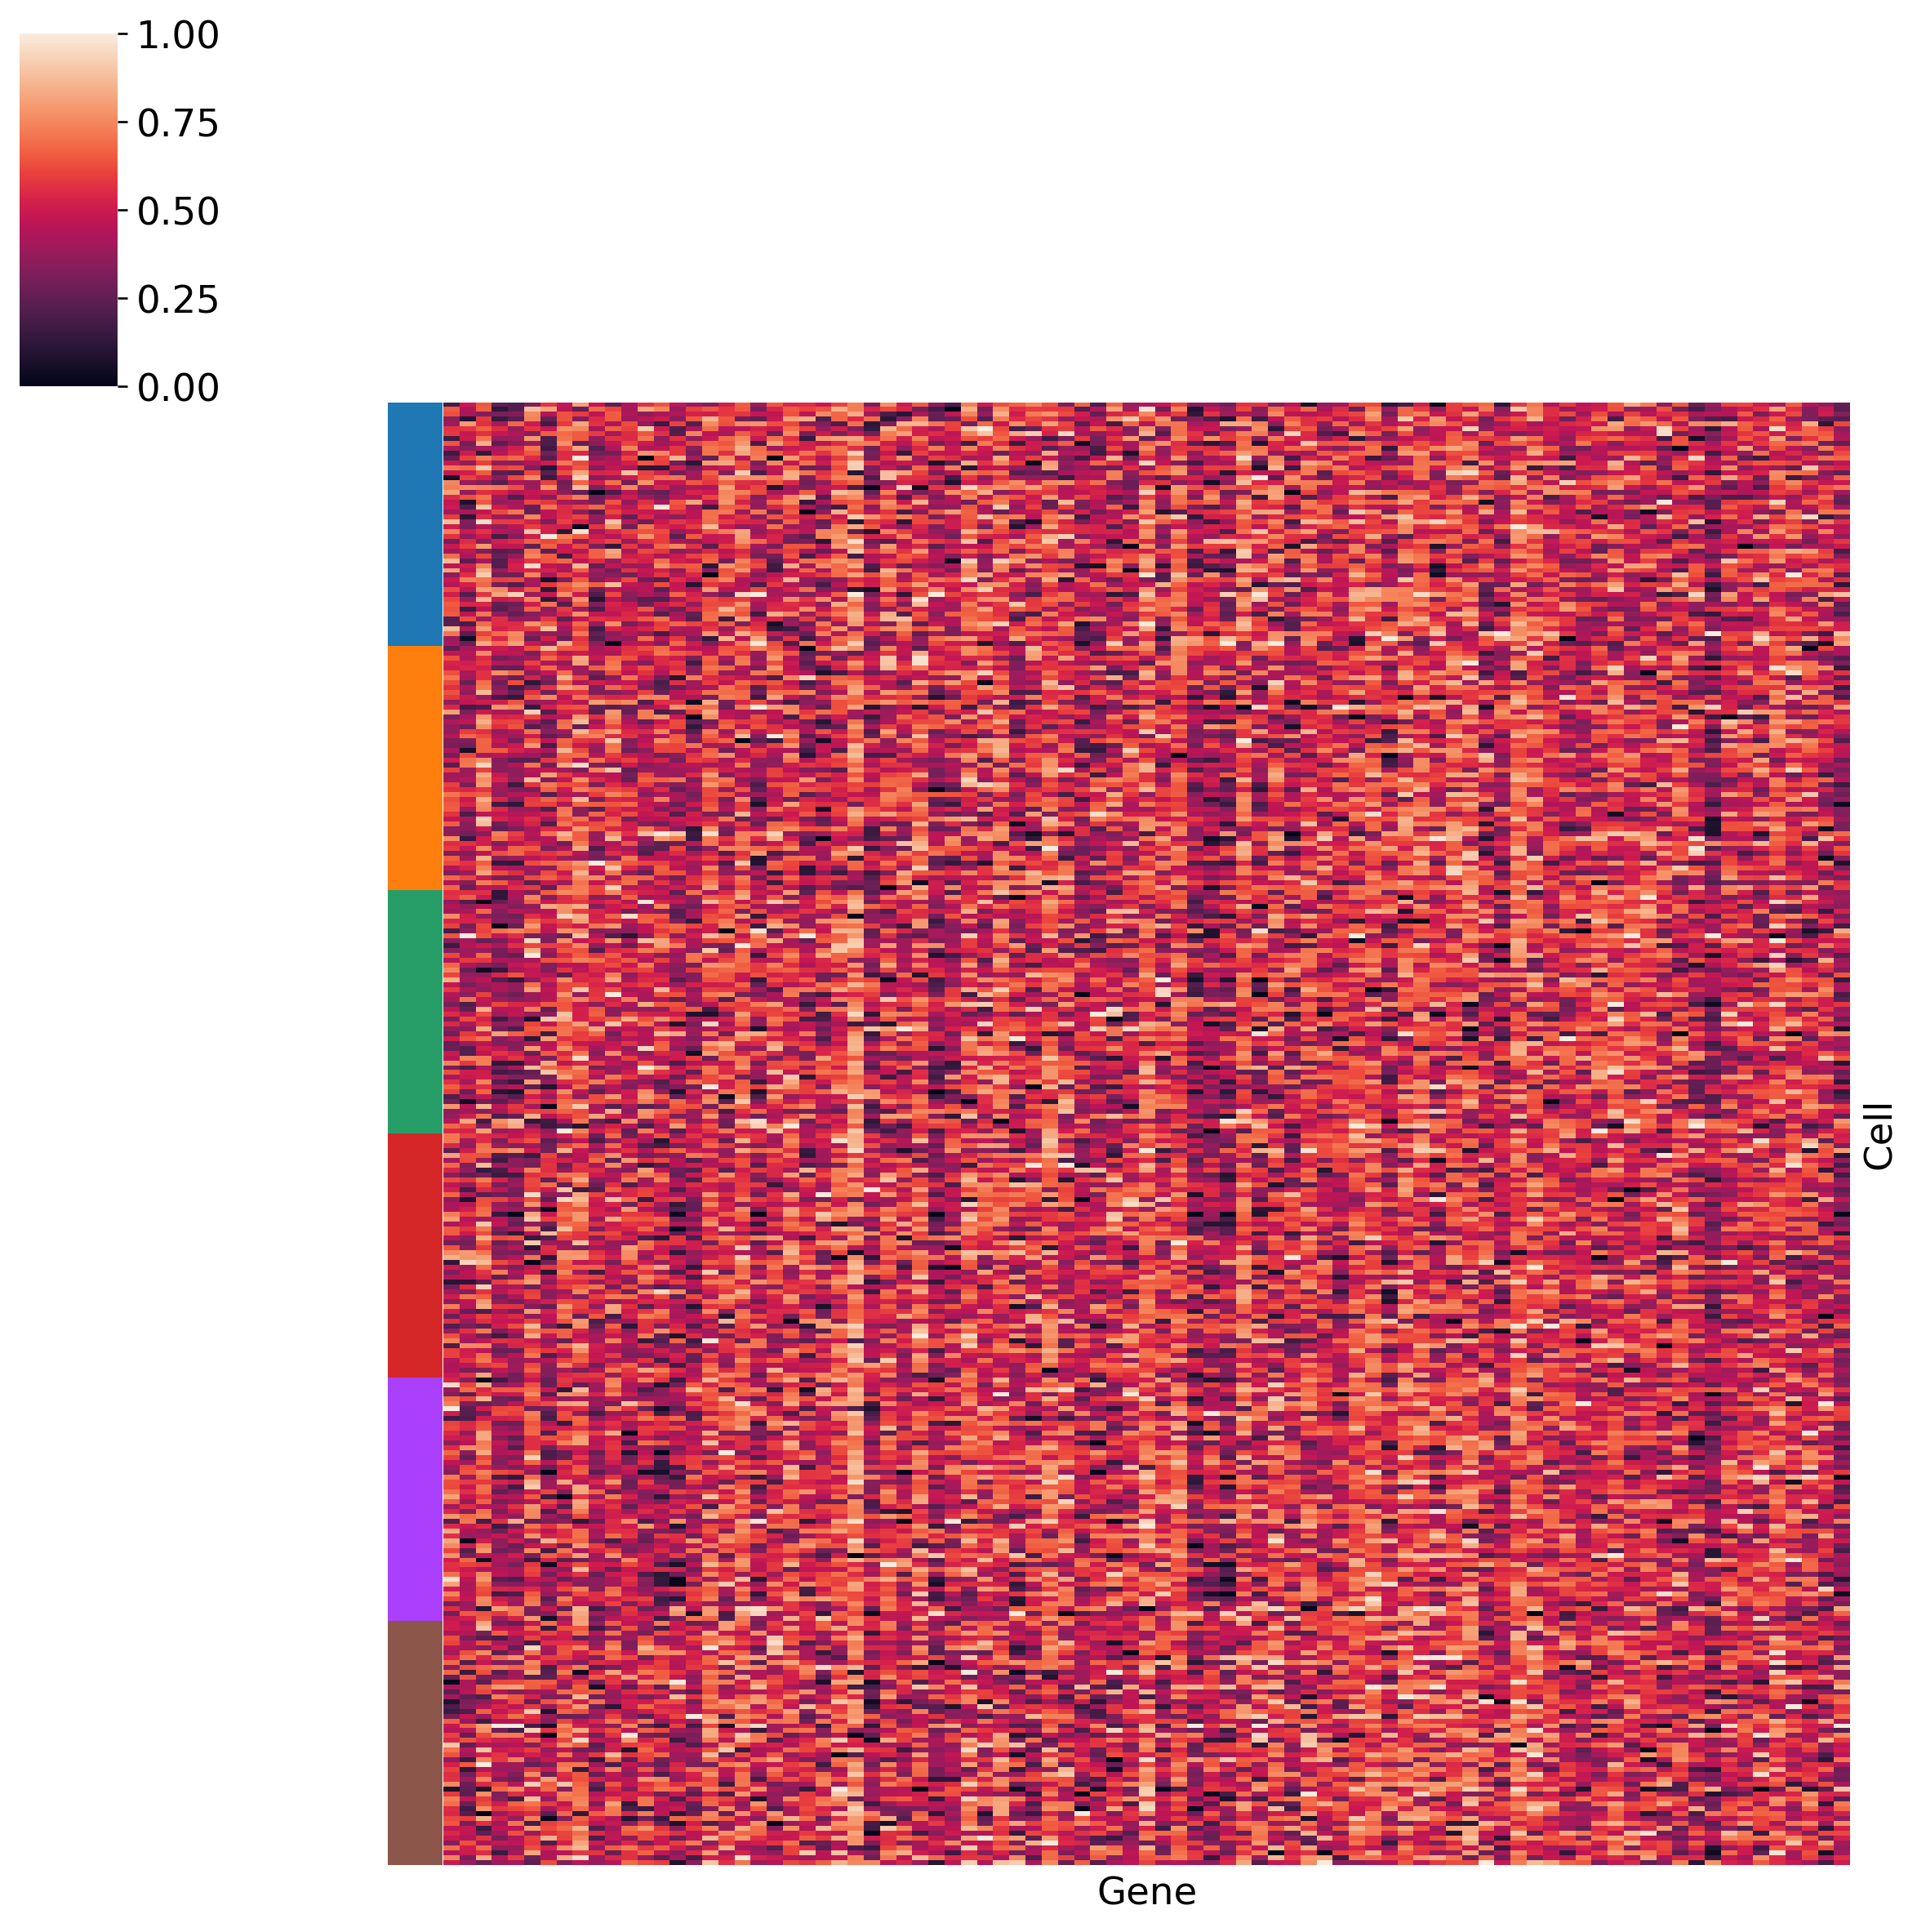

In [22]:
de_genes = np.where(sim_true_norm6.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)[0]

# stratified sampling
total_samples = 300
total_cats = len(sim_true_norm6.obs.Group.cat.categories)
obs_idx = []
for c in sim_true_norm6.obs.Group.cat.categories:
    obs_idx.extend(list(np.random.choice(list(np.where(sim_true_norm6.obs.Group == c)[0]), 
                                         total_samples//total_cats, 
                                         replace=False)))

ax = sc.pl.clustermap(sim_true_norm6[obs_idx, de_genes], 'Group', use_raw=False,
                      standard_scale=1, row_cluster=False, show=False, xticklabels=False, yticklabels=False)

gene_order = ax.dendrogram_col.reordered_ind # preserve gene order from true counts to make heatmaps comparable
de_genes = de_genes[gene_order]

ax = sc.pl.clustermap(sim_raw_norm6[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_zinb_norm6[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_mse_norm6[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)